In [1]:
# prompt: mount to drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import pickle

data_path = "/content/drive/My Drive/project2_data_v2.npz"
data = np.load(data_path, allow_pickle=True, encoding='latin1')

print(data.files)

['data']


In [3]:
stroke_data = data['data'].item()

In [8]:
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import gc

import cv2
import numpy as np

import cv2
import numpy as np

def generate_inertial_views(window, image_size= 128):
    x, y, z = window[:, 0], window[:, 1], window[:, 2]

    def normalize(v):
        v = np.array(v)
        v_min, v_max = v.min(), v.max()
        v_range = v_max - v_min if v_max != v_min else 1.0
        return ((v - v_min) / v_range * (image_size - 1)).astype(np.int32)

    x_n = normalize(x)
    y_n = normalize(y)
    z_n = normalize(z)

    img = np.ones((image_size, image_size, 3), dtype=np.uint8) * 255

    def draw_line(a, b, color):
        pts = np.stack([a, b], axis=1)
        for i in range(len(pts) - 1):
            pt1 = tuple(pts[i])
            pt2 = tuple(pts[i + 1])
            cv2.line(img, pt1, pt2, color=color, lineType=cv2.LINE_AA)

    draw_line(x_n, y_n, (255, 0, 0))   # Red = XY
    draw_line(x_n, z_n, (0, 255, 0))   # Green = XZ
    draw_line(y_n, z_n, (0, 0, 255))   # Blue = YZ

    return img

In [23]:
from scipy.signal import butter, filtfilt
import numpy as np


def filter_acceleration(acc, sample_rate):
    nyq = 0.5 * sample_rate
    b, a = butter(4, 5 / nyq, btype='low')
    return np.stack([filtfilt(b, a, acc[:, i]) for i in range(3)], axis=1)

In [24]:
def extract_segment_per_full_annotation(stroke_data, sample_rate=100.0):
    X, y, groups = [], [], []

    for subject_id, subject_data in stroke_data.items():

        for sensor_name, sensor_data in subject_data.sensors.items():
            acc = sensor_data.local_frame.acc
            annotations = subject_data.annotations[sensor_name]
            filtered_acc = filter_acceleration(acc, sensor_data.sample_rate)

            for _, row in annotations.iterrows():
                start_idx = int(row['Begin'] * sample_rate)
                end_idx = int(row['End'] * sample_rate)

                if end_idx > len(filtered_acc):
                    continue

                if segment.shape[0] < 10:
                  continue

                segment = filtered_acc[start_idx:end_idx]

                img = generate_inertial_views(segment)
                X.append(img)
                y.append(row['Label'])
                groups.append(subject_id)

    return np.array(X), np.array(y), np.array(groups)

In [12]:
class EfficientNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        weights = EfficientNet_B0_Weights.IMAGENET1K_V1
        model = efficientnet_b0(weights=weights)
        self.backbone = model.features
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(model.classifier[1].in_features, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)
        x = self.classifier(x)
        return x

In [13]:
def plot_conf_matrix(y_true, y_pred, classes, dataset_name=""):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(classes)))
    fig, ax = plt.subplots(figsize=(8, 6))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax, cmap='viridis', xticks_rotation=45, colorbar=True)

    ax.set_title(f"{dataset_name} Dataset - Confusion Matrix\n", fontsize=14)
    ax.set_xlabel("Predicted label", fontsize=12)
    ax.set_ylabel("True label", fontsize=12)
    ax.grid(False)

    plt.tight_layout()
    plt.show()

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_multiclass_roc(y_true, y_scores, label_encoder, dataset_name=""):

    classes = label_encoder.classes_
    onehot = OneHotEncoder(sparse_output=False).fit_transform(y_true.reshape(-1, 1))

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)

    for class_id in range(len(classes)):
        fpr, tpr, _ = roc_curve(onehot[:, class_id], y_scores[:, class_id])
        auc = roc_auc_score(onehot[:, class_id], y_scores[:, class_id])
        ax.plot(fpr, tpr, label=f"ROC curve for {classes[class_id]}, ROC-AUC: {auc:.2f}")

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f"{dataset_name} Multiclass ROC-AUC Curves\n", fontsize=14)
    ax.legend(loc='lower right')
    fig.tight_layout()
    plt.show()

In [15]:
def plot_rgb_samples(X, y, title_prefix="", max_samples=2):
    indices = [i for i, label in enumerate(y) if label == "P2P"]
    selected = np.random.choice(indices, size=min(max_samples, len(indices)), replace=False)
    for idx in selected:
        plt.imshow(X[idx])
        plt.title(f"{title_prefix} Label: {y[idx]}")
        plt.axis('off')
        plt.show()

In [16]:
from collections import Counter

print("=== STROKE DATASET ===")
X_stroke, y_stroke, g_stroke = extract_segment_per_full_annotation(stroke_data)
print(f"Stroke Data: {X_stroke.shape}")

print(f"\nUnique lables in Stroke data :{np.unique(y_stroke)}\n")

label_counts_stroke = Counter(y_stroke)

for label, count in label_counts_stroke.items():
    print(f"{label}: {count}")

=== STROKE DATASET ===
Stroke Data: (2976, 128, 128, 3)

Unique lables in Stroke data :['Discard' 'H2M' 'P2P' 'Rep' 'WR']

Discard: 696
P2P: 1797
WR: 153
Rep: 245
H2M: 85


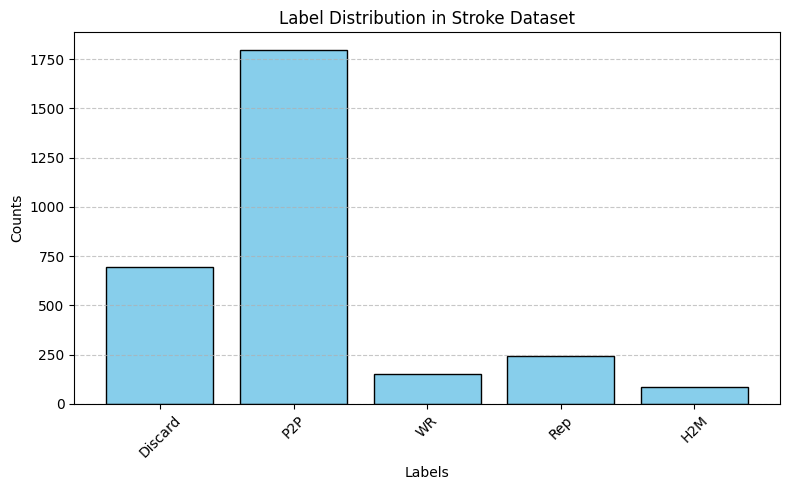

In [17]:
label_counts_stroke = Counter(y_stroke)

labels_stroke = list(label_counts_stroke.keys())
counts_stroke = list(label_counts_stroke.values())

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(labels_stroke, counts_stroke, color='skyblue', edgecolor='black')
plt.title("Label Distribution in Stroke Dataset")
plt.xlabel("Labels")
plt.ylabel("Counts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

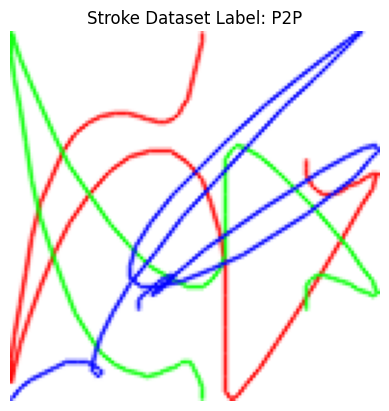

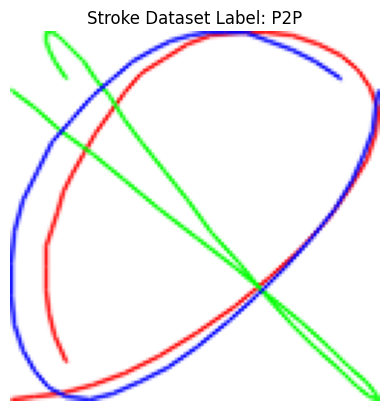

In [18]:
plot_rgb_samples(X_stroke, y_stroke, "Stroke Dataset")

In [19]:
def repeated_subject_stratified_split(X, y, groups, n_splits=5, train_ratio=0.8, seed=42):
    np.random.seed(seed)
    unique_subjects = np.unique(groups)
    total_subjects = len(unique_subjects)
    n_train = int(train_ratio * total_subjects)
    results = []

    for i in range(n_splits):
        shuffled_subjects = np.random.permutation(unique_subjects)
        train_subjects = shuffled_subjects[:n_train]
        test_subjects = shuffled_subjects[n_train:]

        train_mask = np.isin(groups, train_subjects)
        test_mask = np.isin(groups, test_subjects)

        X_train, y_train = X[train_mask], np.array(y)[train_mask]
        X_test, y_test = X[test_mask], np.array(y)[test_mask]

        print(f"\nFold {i+1}/{n_splits}")
        print(f"  Train subjects: {train_subjects}")
        print(f"  Test subjects: {test_subjects}")
        print(f"  Train label counts: {dict(Counter(y_train))}")
        print(f"  Test label counts: {dict(Counter(y_test))}")

        results.append((X_train, y_train, X_test, y_test))

    return results

In [27]:
from sklearn.metrics import accuracy_score

def train_on_split(X_train, y_train, X_test, y_test, label_encoder, num_epochs=10, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    gc.collect()
    torch.cuda.empty_cache()

    model = EfficientNetClassifier(num_classes=len(label_encoder.classes_)).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    X_train_torch = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
    y_train_torch = torch.tensor(label_encoder.transform(y_train), dtype=torch.long)
    X_test_torch = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
    y_test_torch = torch.tensor(label_encoder.transform(y_test), dtype=torch.long).to(device)

    train_loader = DataLoader(TensorDataset(X_train_torch, y_train_torch), batch_size=batch_size, shuffle=True)

    train_losses = []
    train_accuracies = []

    model.train()
    for epoch in range(1, num_epochs + 1):
        total_loss, correct, total = 0.0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * xb.size(0)
            correct += (out.argmax(1) == yb).sum().item()
            total += yb.size(0)

        average_loss = total_loss / total
        average_acc = correct / total
        train_losses.append(average_loss)
        train_accuracies.append(average_acc)
        print(f"  Epoch {epoch}/{num_epochs} - Loss: {total_loss/total:.4f} - Acc: {correct/total:.4f}")


    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.tight_layout()
    plt.show()

    model.eval()
    with torch.no_grad():
        outputs = model(X_test_torch)
        preds = torch.argmax(outputs, dim=1)
        probs = torch.softmax(outputs, dim=1)

    return y_test_torch.cpu().numpy(), preds.cpu().numpy(), probs.cpu().numpy()


Fold 1/7
  Train subjects: [ 9 10 21 15 13 26 30 29 24 11 22 33 14 25]
  Test subjects: [18 23 28 16]
  Train label counts: {np.str_('Discard'): 544, np.str_('P2P'): 1416, np.str_('WR'): 136, np.str_('Rep'): 193, np.str_('H2M'): 70}
  Test label counts: {np.str_('Discard'): 152, np.str_('P2P'): 381, np.str_('WR'): 17, np.str_('Rep'): 52, np.str_('H2M'): 15}

Fold 2/7
  Train subjects: [29 18 16 11 21 23 13 25 28 22  9 14 30 33]
  Test subjects: [15 26 24 10]
  Train label counts: {np.str_('Discard'): 537, np.str_('P2P'): 1398, np.str_('WR'): 119, np.str_('Rep'): 172, np.str_('H2M'): 74}
  Test label counts: {np.str_('Discard'): 159, np.str_('P2P'): 399, np.str_('H2M'): 11, np.str_('WR'): 34, np.str_('Rep'): 73}

Fold 3/7
  Train subjects: [33 10 15  9 23 18 14 25 21 13 16 24 11 30]
  Test subjects: [26 28 29 22]
  Train label counts: {np.str_('Discard'): 546, np.str_('P2P'): 1411, np.str_('WR'): 121, np.str_('Rep'): 184, np.str_('H2M'): 75}
  Test label counts: {np.str_('Discard'): 15

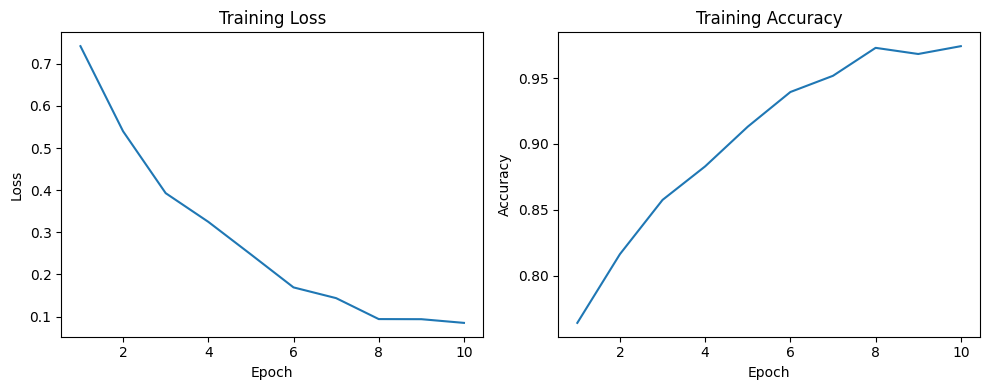


====== Fold 2 ======
  Epoch 1/10 - Loss: 0.7212 - Acc: 0.7735
  Epoch 2/10 - Loss: 0.5361 - Acc: 0.8100
  Epoch 3/10 - Loss: 0.3889 - Acc: 0.8678
  Epoch 4/10 - Loss: 0.2794 - Acc: 0.9022
  Epoch 5/10 - Loss: 0.2871 - Acc: 0.8965
  Epoch 6/10 - Loss: 0.1556 - Acc: 0.9470
  Epoch 7/10 - Loss: 0.1329 - Acc: 0.9517
  Epoch 8/10 - Loss: 0.0935 - Acc: 0.9678
  Epoch 9/10 - Loss: 0.0648 - Acc: 0.9787
  Epoch 10/10 - Loss: 0.0853 - Acc: 0.9739


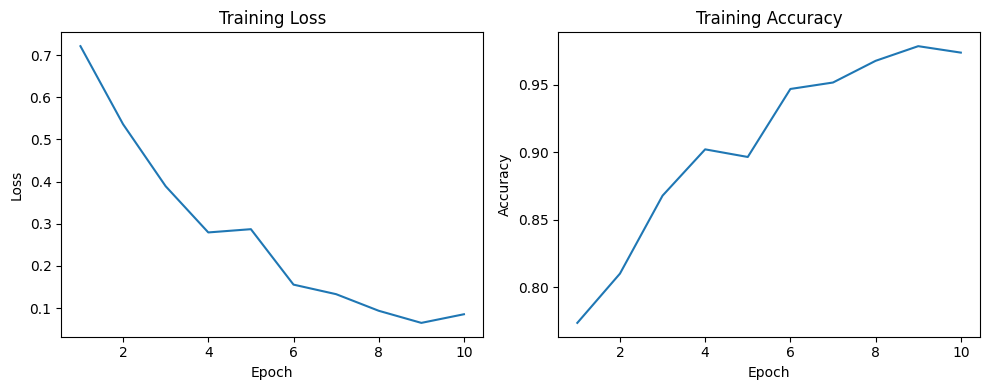


====== Fold 3 ======
  Epoch 1/10 - Loss: 0.7295 - Acc: 0.7621
  Epoch 2/10 - Loss: 0.5101 - Acc: 0.8301
  Epoch 3/10 - Loss: 0.3843 - Acc: 0.8656
  Epoch 4/10 - Loss: 0.3067 - Acc: 0.8943
  Epoch 5/10 - Loss: 0.2222 - Acc: 0.9208
  Epoch 6/10 - Loss: 0.1943 - Acc: 0.9367
  Epoch 7/10 - Loss: 0.1391 - Acc: 0.9538
  Epoch 8/10 - Loss: 0.1436 - Acc: 0.9435
  Epoch 9/10 - Loss: 0.1136 - Acc: 0.9623
  Epoch 10/10 - Loss: 0.1356 - Acc: 0.9551


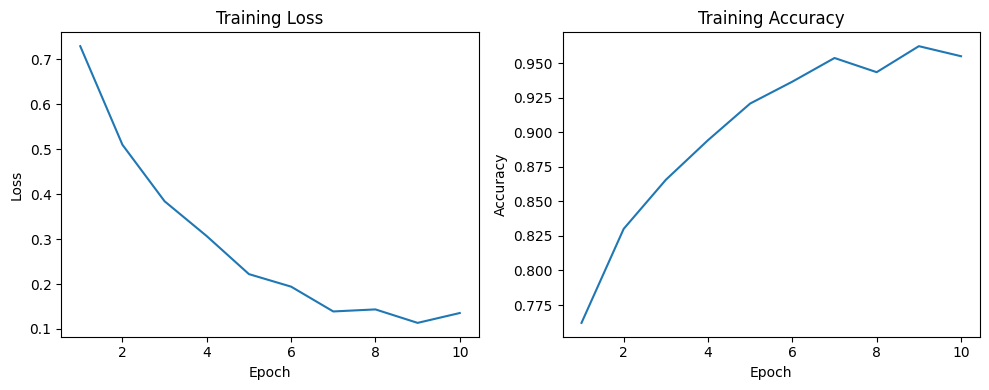


====== Fold 4 ======
  Epoch 1/10 - Loss: 0.7376 - Acc: 0.7723
  Epoch 2/10 - Loss: 0.5132 - Acc: 0.8262
  Epoch 3/10 - Loss: 0.4081 - Acc: 0.8464
  Epoch 4/10 - Loss: 0.2910 - Acc: 0.8885
  Epoch 5/10 - Loss: 0.2057 - Acc: 0.9237
  Epoch 6/10 - Loss: 0.1509 - Acc: 0.9482
  Epoch 7/10 - Loss: 0.1595 - Acc: 0.9460
  Epoch 8/10 - Loss: 0.1649 - Acc: 0.9452
  Epoch 9/10 - Loss: 0.2481 - Acc: 0.9166
  Epoch 10/10 - Loss: 0.0876 - Acc: 0.9693


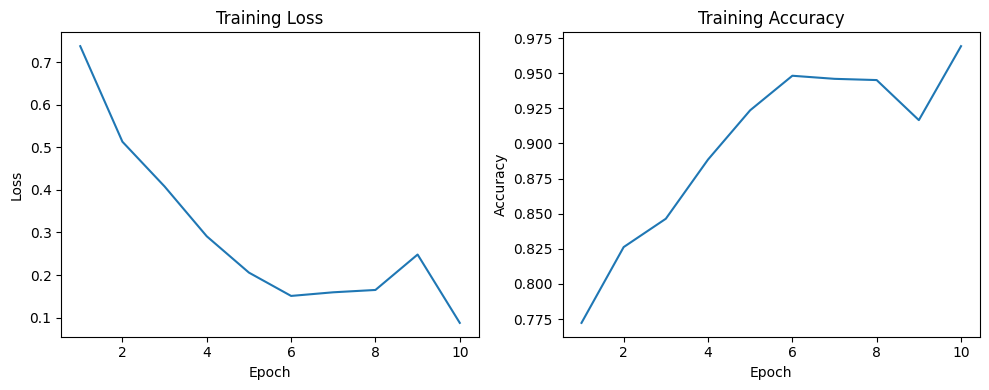


====== Fold 5 ======
  Epoch 1/10 - Loss: 0.7216 - Acc: 0.7796
  Epoch 2/10 - Loss: 0.5008 - Acc: 0.8246
  Epoch 3/10 - Loss: 0.3550 - Acc: 0.8699
  Epoch 4/10 - Loss: 0.2561 - Acc: 0.9123
  Epoch 5/10 - Loss: 0.1955 - Acc: 0.9268
  Epoch 6/10 - Loss: 0.1880 - Acc: 0.9354
  Epoch 7/10 - Loss: 0.1630 - Acc: 0.9431
  Epoch 8/10 - Loss: 0.1758 - Acc: 0.9405
  Epoch 9/10 - Loss: 0.0807 - Acc: 0.9760
  Epoch 10/10 - Loss: 0.0947 - Acc: 0.9713


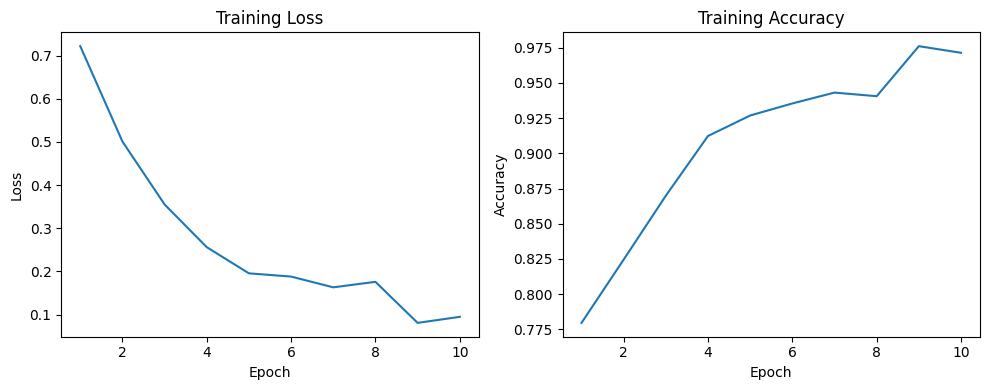


====== Fold 6 ======
  Epoch 1/10 - Loss: 0.7064 - Acc: 0.7775
  Epoch 2/10 - Loss: 0.4822 - Acc: 0.8352
  Epoch 3/10 - Loss: 0.3725 - Acc: 0.8726
  Epoch 4/10 - Loss: 0.2446 - Acc: 0.9159
  Epoch 5/10 - Loss: 0.2272 - Acc: 0.9227
  Epoch 6/10 - Loss: 0.1917 - Acc: 0.9372
  Epoch 7/10 - Loss: 0.1112 - Acc: 0.9622
  Epoch 8/10 - Loss: 0.1383 - Acc: 0.9554
  Epoch 9/10 - Loss: 0.1274 - Acc: 0.9537
  Epoch 10/10 - Loss: 0.0751 - Acc: 0.9766


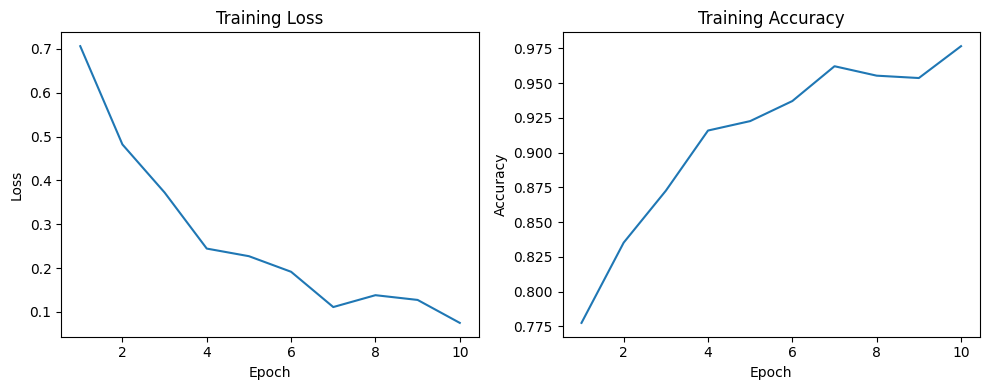


====== Fold 7 ======
  Epoch 1/10 - Loss: 0.7543 - Acc: 0.7694
  Epoch 2/10 - Loss: 0.5123 - Acc: 0.8244
  Epoch 3/10 - Loss: 0.3717 - Acc: 0.8678
  Epoch 4/10 - Loss: 0.2980 - Acc: 0.8978
  Epoch 5/10 - Loss: 0.2264 - Acc: 0.9162
  Epoch 6/10 - Loss: 0.2040 - Acc: 0.9308
  Epoch 7/10 - Loss: 0.1470 - Acc: 0.9470
  Epoch 8/10 - Loss: 0.1057 - Acc: 0.9662
  Epoch 9/10 - Loss: 0.1208 - Acc: 0.9629
  Epoch 10/10 - Loss: 0.0904 - Acc: 0.9675


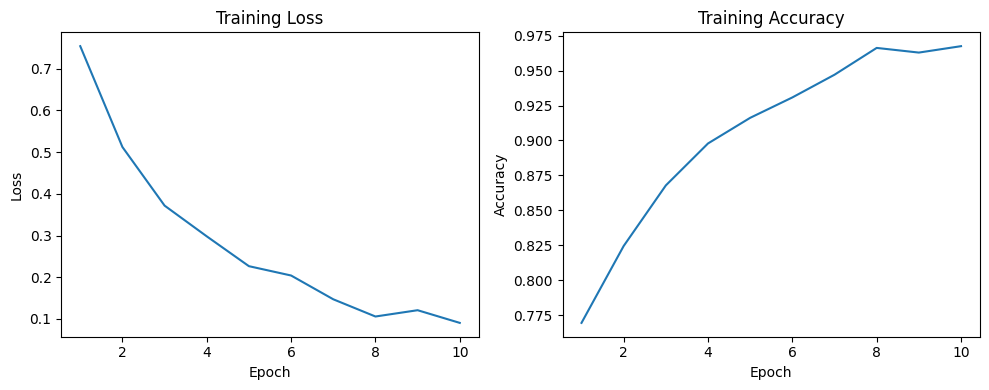

In [28]:
label_encoder_stroke = LabelEncoder().fit(y_stroke)

#repeated subject splits (5-fold, stratified)
splits = repeated_subject_stratified_split(X_stroke, y_stroke, g_stroke, n_splits=7)

all_y_true_stroke, all_y_pred_stroke, all_y_scores_stroke = [], [], []

# 4. Train and evaluate on each fold
for i, (X_train, y_train, X_test, y_test) in enumerate(splits, 1):
    print(f"\n====== Fold {i} ======")
    yt_stroke, yp_stroke, ys_stroke = train_on_split(X_train, y_train, X_test, y_test, label_encoder_stroke)
    all_y_true_stroke.extend(yt_stroke)
    all_y_pred_stroke.extend(yp_stroke)
    all_y_scores_stroke.extend(ys_stroke)

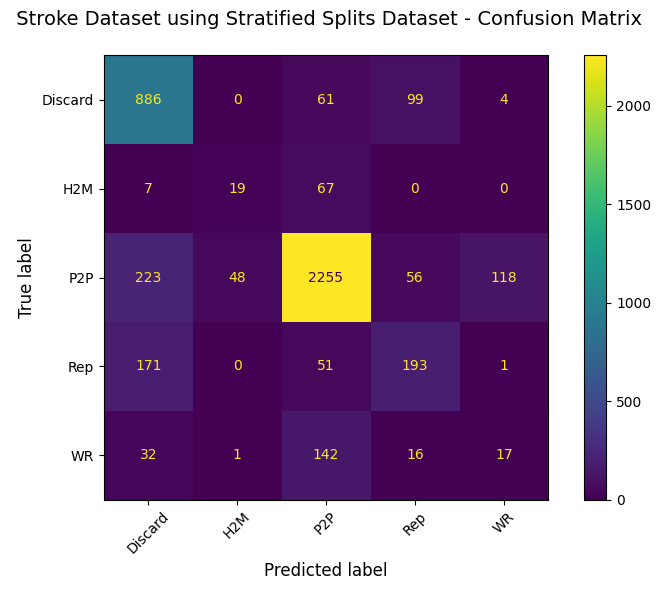

In [29]:
#Stroke Data Visualization using stratified splits

all_y_true_stroke = np.array(all_y_true_stroke)
all_y_pred_stroke = np.array(all_y_pred_stroke)
all_y_scores_stroke = np.array(all_y_scores_stroke)

plot_conf_matrix(all_y_true_stroke, all_y_pred_stroke, label_encoder_stroke.classes_," Stroke Dataset using Stratified Splits")

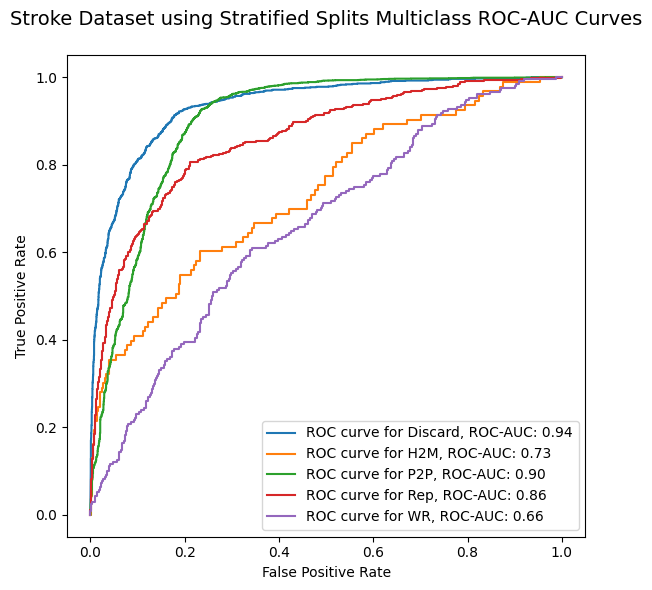

In [47]:
plot_multiclass_roc(all_y_true_stroke, all_y_scores_stroke,label_encoder_stroke, "Stroke Dataset using Stratified Splits")

In [35]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score

def train_losocv_model(X, y, groups, label_encoder, num_epochs=10, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logo = LeaveOneGroupOut()

    all_preds, all_true, all_probs = [], [], []

    for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups), 1):
        print(f"\n[LOSOCV Fold {fold}] Test Subject: {np.unique(groups[test_idx])[0]}")

        X_train = X[train_idx]
        y_train = np.array(y)[train_idx]
        X_test = X[test_idx]
        y_test = np.array(y)[test_idx]

        gc.collect()
        torch.cuda.empty_cache()

        model = EfficientNetClassifier(num_classes=len(label_encoder.classes_)).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        X_train_torch = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
        y_train_torch = torch.tensor(label_encoder.transform(y_train), dtype=torch.long)
        X_test_torch = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
        y_test_torch = torch.tensor(label_encoder.transform(y_test), dtype=torch.long).to(device)

        train_losses = []
        train_accuracies = []

        train_loader = DataLoader(TensorDataset(X_train_torch, y_train_torch), batch_size=batch_size, shuffle=True)

        model.train()
        for epoch in range(1, num_epochs + 1):
            total_loss, correct, total = 0.0, 0, 0
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                out = model(xb)
                loss = criterion(out, yb)
                loss.backward()
                optimizer.step()

                total_loss += loss.item() * xb.size(0)
                correct += (out.argmax(1) == yb).sum().item()
                total += yb.size(0)

            average_loss = total_loss / total
            average_acc = correct / total
            train_losses.append(average_loss)
            train_accuracies.append(average_acc)
            print(f"  Epoch {epoch}/{num_epochs} - Loss: {total_loss/total:.4f} - Acc: {correct/total:.4f}")

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.subplot(1, 2, 2)
        plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training Accuracy')
        plt.tight_layout()
        plt.show()

        model.eval()
        with torch.no_grad():
            outputs = model(X_test_torch)
            preds = torch.argmax(outputs, dim=1)
            probs = torch.softmax(outputs, dim=1)

        all_true.extend(y_test_torch.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

    return np.array(all_true), np.array(all_preds), np.array(all_probs)


[LOSOCV Fold 1] Test Subject: 9
  Epoch 1/10 - Loss: 0.7284 - Acc: 0.7658
  Epoch 2/10 - Loss: 0.4977 - Acc: 0.8274
  Epoch 3/10 - Loss: 0.3742 - Acc: 0.8735
  Epoch 4/10 - Loss: 0.2981 - Acc: 0.8923
  Epoch 5/10 - Loss: 0.2338 - Acc: 0.9196
  Epoch 6/10 - Loss: 0.1769 - Acc: 0.9402
  Epoch 7/10 - Loss: 0.1180 - Acc: 0.9553
  Epoch 8/10 - Loss: 0.1435 - Acc: 0.9499
  Epoch 9/10 - Loss: 0.1314 - Acc: 0.9539
  Epoch 10/10 - Loss: 0.1020 - Acc: 0.9632


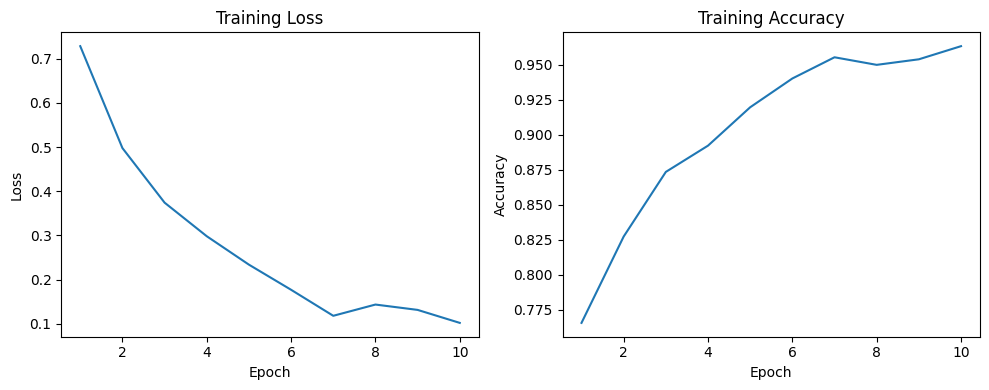


[LOSOCV Fold 2] Test Subject: 10
  Epoch 1/10 - Loss: 0.7034 - Acc: 0.7793
  Epoch 2/10 - Loss: 0.5143 - Acc: 0.8318
  Epoch 3/10 - Loss: 0.4351 - Acc: 0.8463
  Epoch 4/10 - Loss: 0.3803 - Acc: 0.8662
  Epoch 5/10 - Loss: 0.3123 - Acc: 0.8918
  Epoch 6/10 - Loss: 0.2532 - Acc: 0.9131
  Epoch 7/10 - Loss: 0.1543 - Acc: 0.9496
  Epoch 8/10 - Loss: 0.2046 - Acc: 0.9276
  Epoch 9/10 - Loss: 0.1825 - Acc: 0.9340
  Epoch 10/10 - Loss: 0.1034 - Acc: 0.9634


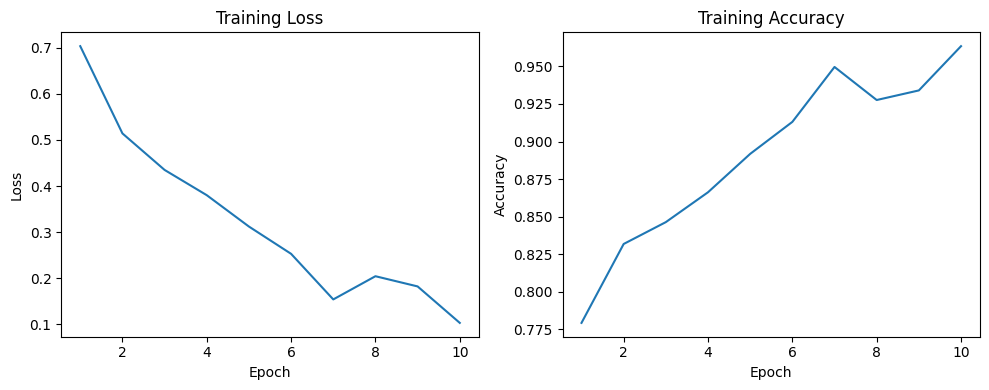


[LOSOCV Fold 3] Test Subject: 11
  Epoch 1/10 - Loss: 0.7460 - Acc: 0.7738
  Epoch 2/10 - Loss: 0.5285 - Acc: 0.8127
  Epoch 3/10 - Loss: 0.4293 - Acc: 0.8479
  Epoch 4/10 - Loss: 0.3223 - Acc: 0.8865
  Epoch 5/10 - Loss: 0.2269 - Acc: 0.9186
  Epoch 6/10 - Loss: 0.2065 - Acc: 0.9269
  Epoch 7/10 - Loss: 0.1995 - Acc: 0.9286
  Epoch 8/10 - Loss: 0.1367 - Acc: 0.9554
  Epoch 9/10 - Loss: 0.1053 - Acc: 0.9676
  Epoch 10/10 - Loss: 0.1163 - Acc: 0.9621


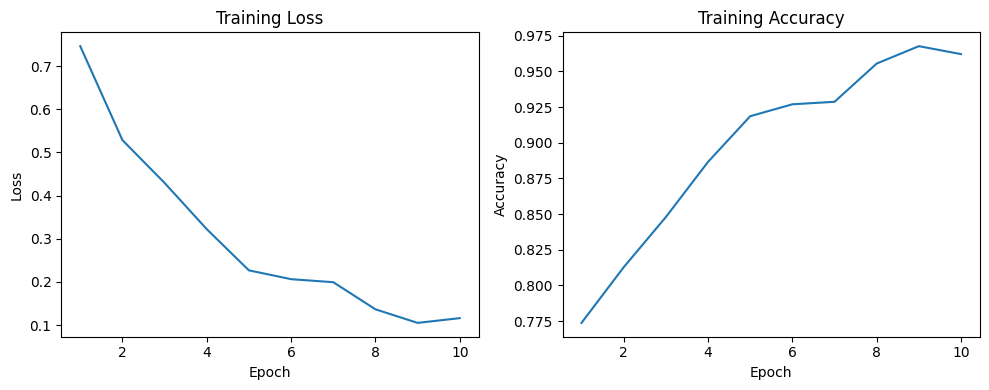


[LOSOCV Fold 4] Test Subject: 13
  Epoch 1/10 - Loss: 0.7326 - Acc: 0.7646
  Epoch 2/10 - Loss: 0.5316 - Acc: 0.8186
  Epoch 3/10 - Loss: 0.4140 - Acc: 0.8516
  Epoch 4/10 - Loss: 0.3384 - Acc: 0.8821
  Epoch 5/10 - Loss: 0.2356 - Acc: 0.9144
  Epoch 6/10 - Loss: 0.2139 - Acc: 0.9201
  Epoch 7/10 - Loss: 0.1613 - Acc: 0.9450
  Epoch 8/10 - Loss: 0.1104 - Acc: 0.9617
  Epoch 9/10 - Loss: 0.1425 - Acc: 0.9517
  Epoch 10/10 - Loss: 0.1204 - Acc: 0.9570


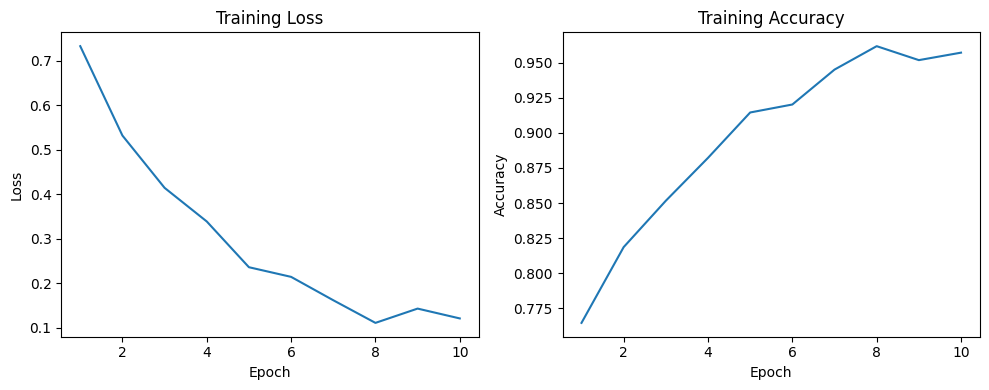


[LOSOCV Fold 5] Test Subject: 14
  Epoch 1/10 - Loss: 0.7286 - Acc: 0.7682
  Epoch 2/10 - Loss: 0.5320 - Acc: 0.8181
  Epoch 3/10 - Loss: 0.4309 - Acc: 0.8500
  Epoch 4/10 - Loss: 0.4043 - Acc: 0.8601
  Epoch 5/10 - Loss: 0.2948 - Acc: 0.9006
  Epoch 6/10 - Loss: 0.2238 - Acc: 0.9225
  Epoch 7/10 - Loss: 0.2408 - Acc: 0.9200
  Epoch 8/10 - Loss: 0.1505 - Acc: 0.9498
  Epoch 9/10 - Loss: 0.1678 - Acc: 0.9437
  Epoch 10/10 - Loss: 0.0960 - Acc: 0.9681


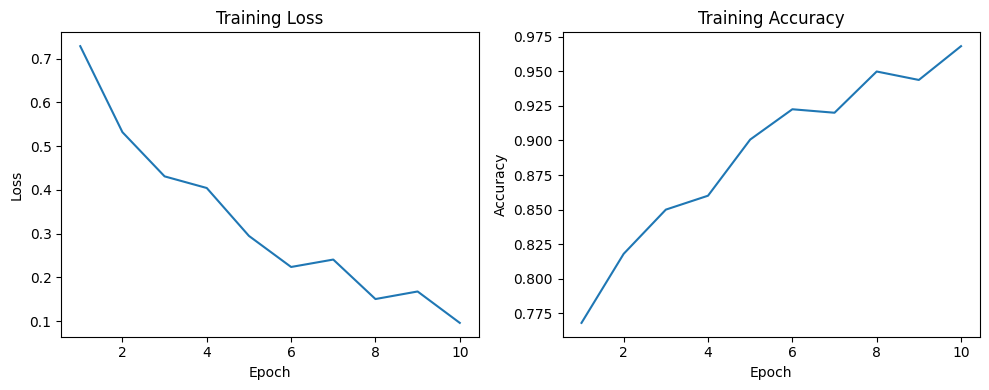


[LOSOCV Fold 6] Test Subject: 15
  Epoch 1/10 - Loss: 0.7371 - Acc: 0.7667
  Epoch 2/10 - Loss: 0.4985 - Acc: 0.8318
  Epoch 3/10 - Loss: 0.3992 - Acc: 0.8637
  Epoch 4/10 - Loss: 0.2708 - Acc: 0.8970
  Epoch 5/10 - Loss: 0.2336 - Acc: 0.9220
  Epoch 6/10 - Loss: 0.2021 - Acc: 0.9259
  Epoch 7/10 - Loss: 0.1441 - Acc: 0.9513
  Epoch 8/10 - Loss: 0.1828 - Acc: 0.9381
  Epoch 9/10 - Loss: 0.0900 - Acc: 0.9721
  Epoch 10/10 - Loss: 0.0900 - Acc: 0.9678


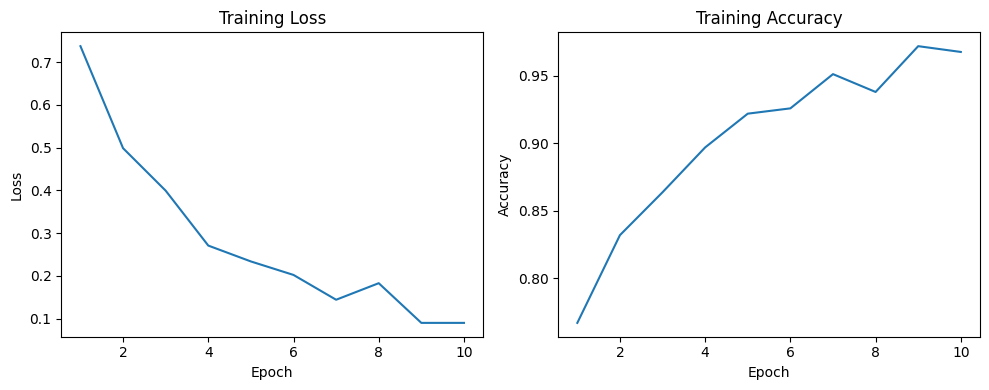


[LOSOCV Fold 7] Test Subject: 16
  Epoch 1/10 - Loss: 0.7522 - Acc: 0.7701
  Epoch 2/10 - Loss: 0.5324 - Acc: 0.8272
  Epoch 3/10 - Loss: 0.4217 - Acc: 0.8538
  Epoch 4/10 - Loss: 0.3116 - Acc: 0.8886
  Epoch 5/10 - Loss: 0.2575 - Acc: 0.9138
  Epoch 6/10 - Loss: 0.2069 - Acc: 0.9266
  Epoch 7/10 - Loss: 0.1368 - Acc: 0.9507
  Epoch 8/10 - Loss: 0.2051 - Acc: 0.9198
  Epoch 9/10 - Loss: 0.1916 - Acc: 0.9337
  Epoch 10/10 - Loss: 0.0693 - Acc: 0.9766


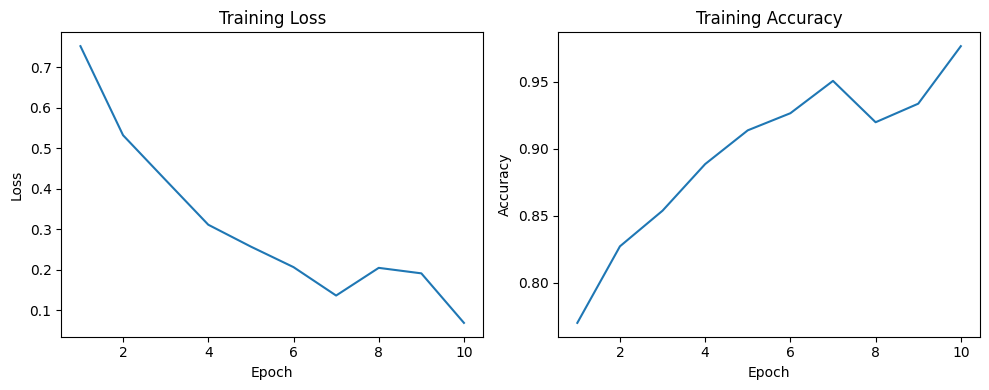


[LOSOCV Fold 8] Test Subject: 18
  Epoch 1/10 - Loss: 0.7440 - Acc: 0.7677
  Epoch 2/10 - Loss: 0.5024 - Acc: 0.8223
  Epoch 3/10 - Loss: 0.3802 - Acc: 0.8631
  Epoch 4/10 - Loss: 0.2976 - Acc: 0.8995
  Epoch 5/10 - Loss: 0.2469 - Acc: 0.9115
  Epoch 6/10 - Loss: 0.1815 - Acc: 0.9370
  Epoch 7/10 - Loss: 0.1587 - Acc: 0.9468
  Epoch 8/10 - Loss: 0.1109 - Acc: 0.9632
  Epoch 9/10 - Loss: 0.1041 - Acc: 0.9632
  Epoch 10/10 - Loss: 0.1444 - Acc: 0.9472


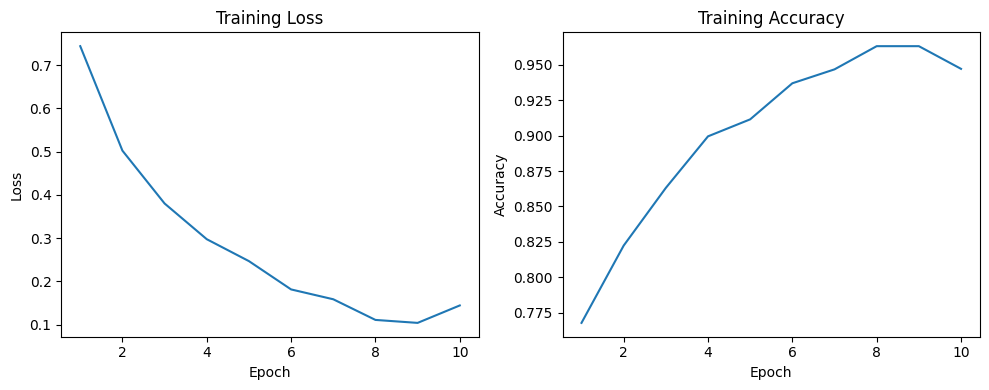


[LOSOCV Fold 9] Test Subject: 21
  Epoch 1/10 - Loss: 0.7302 - Acc: 0.7625
  Epoch 2/10 - Loss: 0.5099 - Acc: 0.8300
  Epoch 3/10 - Loss: 0.3809 - Acc: 0.8650
  Epoch 4/10 - Loss: 0.3038 - Acc: 0.8924
  Epoch 5/10 - Loss: 0.2315 - Acc: 0.9137
  Epoch 6/10 - Loss: 0.1797 - Acc: 0.9365
  Epoch 7/10 - Loss: 0.1332 - Acc: 0.9534
  Epoch 8/10 - Loss: 0.1166 - Acc: 0.9570
  Epoch 9/10 - Loss: 0.1351 - Acc: 0.9542
  Epoch 10/10 - Loss: 0.0996 - Acc: 0.9653


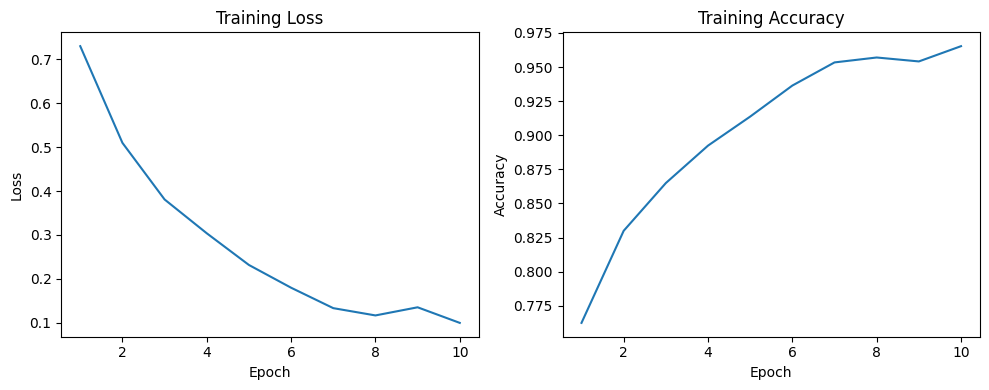


[LOSOCV Fold 10] Test Subject: 22
  Epoch 1/10 - Loss: 0.7517 - Acc: 0.7563
  Epoch 2/10 - Loss: 0.5396 - Acc: 0.8210
  Epoch 3/10 - Loss: 0.3980 - Acc: 0.8626
  Epoch 4/10 - Loss: 0.3132 - Acc: 0.8959
  Epoch 5/10 - Loss: 0.2545 - Acc: 0.9112
  Epoch 6/10 - Loss: 0.1603 - Acc: 0.9401
  Epoch 7/10 - Loss: 0.1624 - Acc: 0.9459
  Epoch 8/10 - Loss: 0.1514 - Acc: 0.9496
  Epoch 9/10 - Loss: 0.1098 - Acc: 0.9653
  Epoch 10/10 - Loss: 0.0736 - Acc: 0.9777


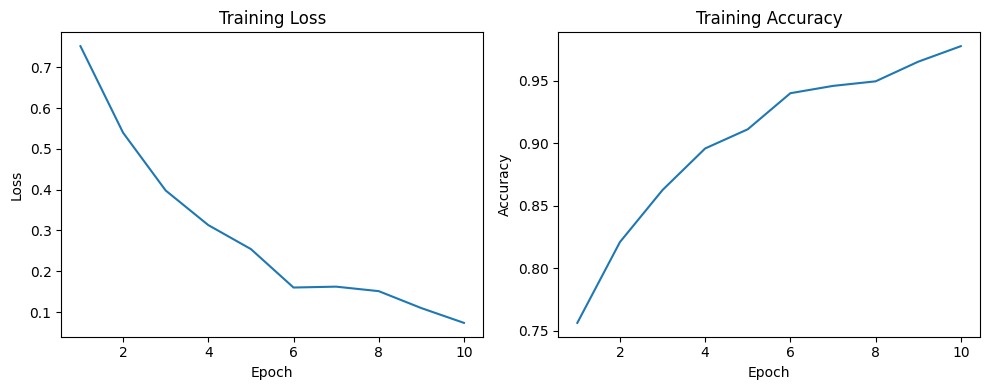


[LOSOCV Fold 11] Test Subject: 23
  Epoch 1/10 - Loss: 0.7342 - Acc: 0.7770
  Epoch 2/10 - Loss: 0.5419 - Acc: 0.8229
  Epoch 3/10 - Loss: 0.4291 - Acc: 0.8488
  Epoch 4/10 - Loss: 0.3191 - Acc: 0.8950
  Epoch 5/10 - Loss: 0.2856 - Acc: 0.8978
  Epoch 6/10 - Loss: 0.1856 - Acc: 0.9380
  Epoch 7/10 - Loss: 0.1468 - Acc: 0.9524
  Epoch 8/10 - Loss: 0.1915 - Acc: 0.9282
  Epoch 9/10 - Loss: 0.1066 - Acc: 0.9608
  Epoch 10/10 - Loss: 0.0949 - Acc: 0.9678


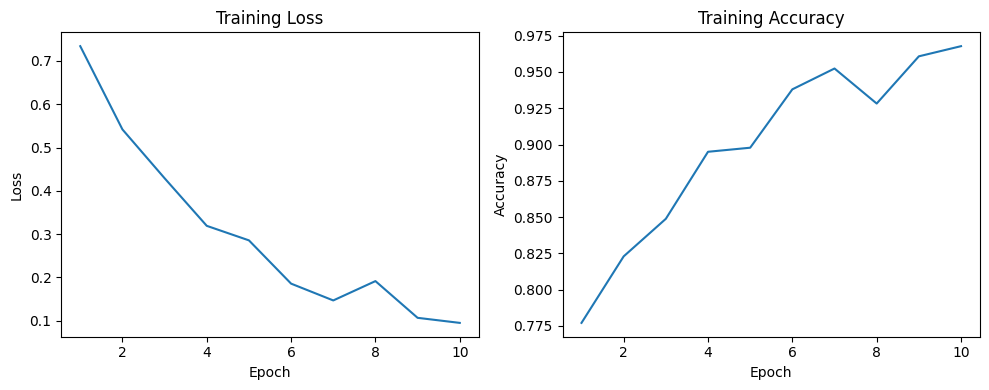


[LOSOCV Fold 12] Test Subject: 24
  Epoch 1/10 - Loss: 0.7326 - Acc: 0.7633
  Epoch 2/10 - Loss: 0.5053 - Acc: 0.8212
  Epoch 3/10 - Loss: 0.3936 - Acc: 0.8572
  Epoch 4/10 - Loss: 0.2900 - Acc: 0.8975
  Epoch 5/10 - Loss: 0.2394 - Acc: 0.9151
  Epoch 6/10 - Loss: 0.1994 - Acc: 0.9324
  Epoch 7/10 - Loss: 0.1390 - Acc: 0.9504
  Epoch 8/10 - Loss: 0.0971 - Acc: 0.9687
  Epoch 9/10 - Loss: 0.1135 - Acc: 0.9604
  Epoch 10/10 - Loss: 0.1254 - Acc: 0.9543


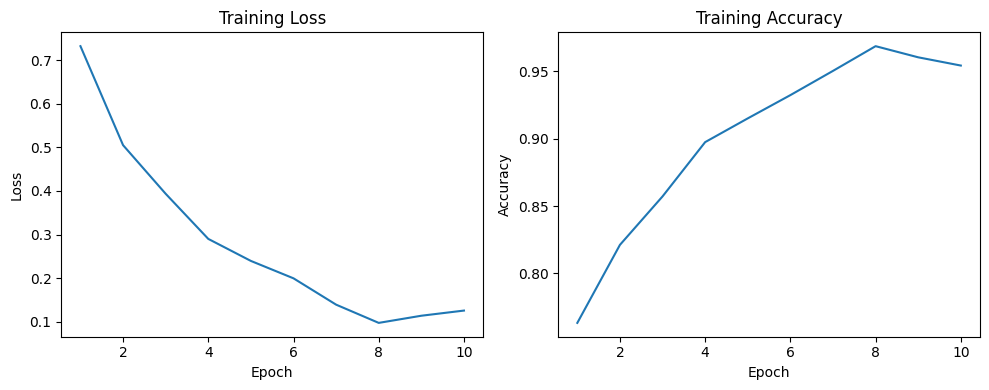


[LOSOCV Fold 13] Test Subject: 25
  Epoch 1/10 - Loss: 0.7400 - Acc: 0.7720
  Epoch 2/10 - Loss: 0.5345 - Acc: 0.8279
  Epoch 3/10 - Loss: 0.4044 - Acc: 0.8622
  Epoch 4/10 - Loss: 0.2656 - Acc: 0.9073
  Epoch 5/10 - Loss: 0.2159 - Acc: 0.9217
  Epoch 6/10 - Loss: 0.1822 - Acc: 0.9351
  Epoch 7/10 - Loss: 0.1097 - Acc: 0.9625
  Epoch 8/10 - Loss: 0.1692 - Acc: 0.9434
  Epoch 9/10 - Loss: 0.1040 - Acc: 0.9618
  Epoch 10/10 - Loss: 0.0606 - Acc: 0.9805


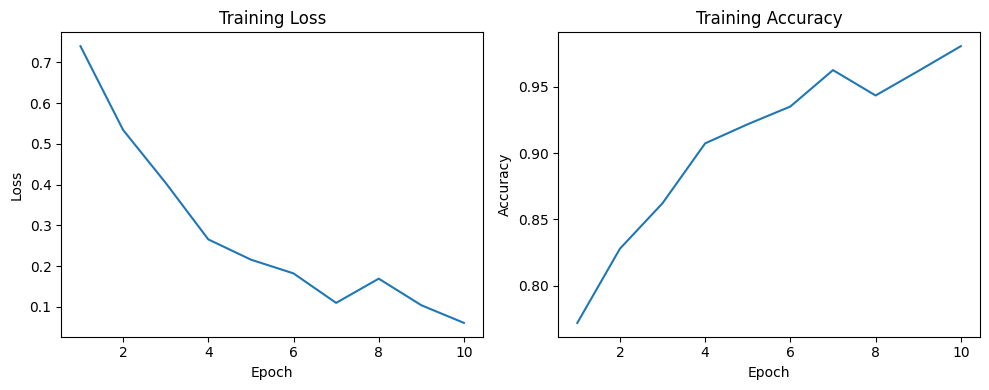


[LOSOCV Fold 14] Test Subject: 26
  Epoch 1/10 - Loss: 0.7322 - Acc: 0.7732
  Epoch 2/10 - Loss: 0.5059 - Acc: 0.8190
  Epoch 3/10 - Loss: 0.3917 - Acc: 0.8589
  Epoch 4/10 - Loss: 0.2797 - Acc: 0.8991
  Epoch 5/10 - Loss: 0.2392 - Acc: 0.9115
  Epoch 6/10 - Loss: 0.1826 - Acc: 0.9326
  Epoch 7/10 - Loss: 0.1598 - Acc: 0.9439
  Epoch 8/10 - Loss: 0.1560 - Acc: 0.9425
  Epoch 9/10 - Loss: 0.1066 - Acc: 0.9637
  Epoch 10/10 - Loss: 0.0752 - Acc: 0.9714


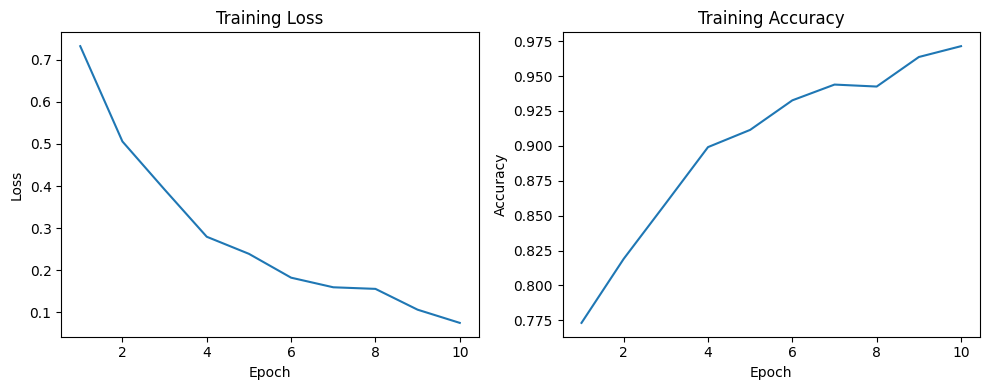


[LOSOCV Fold 15] Test Subject: 28
  Epoch 1/10 - Loss: 0.7341 - Acc: 0.7742
  Epoch 2/10 - Loss: 0.4964 - Acc: 0.8272
  Epoch 3/10 - Loss: 0.3891 - Acc: 0.8618
  Epoch 4/10 - Loss: 0.2833 - Acc: 0.8998
  Epoch 5/10 - Loss: 0.2325 - Acc: 0.9194
  Epoch 6/10 - Loss: 0.2078 - Acc: 0.9274
  Epoch 7/10 - Loss: 0.1587 - Acc: 0.9435
  Epoch 8/10 - Loss: 0.1088 - Acc: 0.9668
  Epoch 9/10 - Loss: 0.0965 - Acc: 0.9647
  Epoch 10/10 - Loss: 0.1092 - Acc: 0.9630


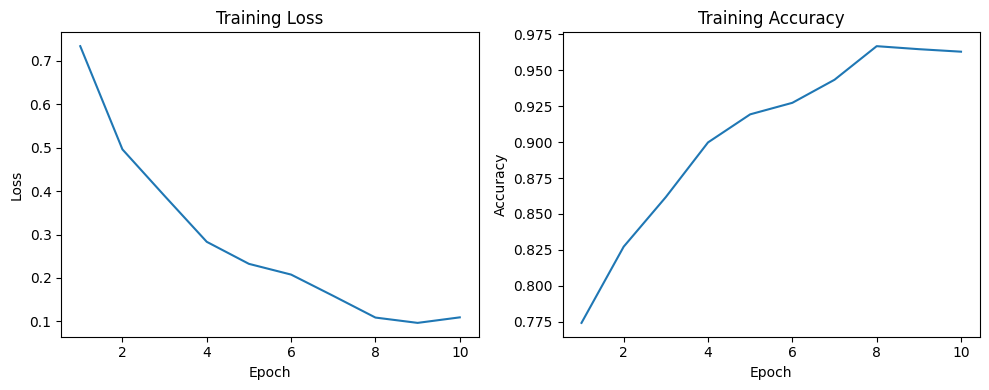


[LOSOCV Fold 16] Test Subject: 29
  Epoch 1/10 - Loss: 0.7496 - Acc: 0.7617
  Epoch 2/10 - Loss: 0.5241 - Acc: 0.8218
  Epoch 3/10 - Loss: 0.3915 - Acc: 0.8600
  Epoch 4/10 - Loss: 0.3150 - Acc: 0.8865
  Epoch 5/10 - Loss: 0.2524 - Acc: 0.9084
  Epoch 6/10 - Loss: 0.1840 - Acc: 0.9293
  Epoch 7/10 - Loss: 0.1253 - Acc: 0.9611
  Epoch 8/10 - Loss: 0.1882 - Acc: 0.9335
  Epoch 9/10 - Loss: 0.1213 - Acc: 0.9590
  Epoch 10/10 - Loss: 0.0953 - Acc: 0.9678


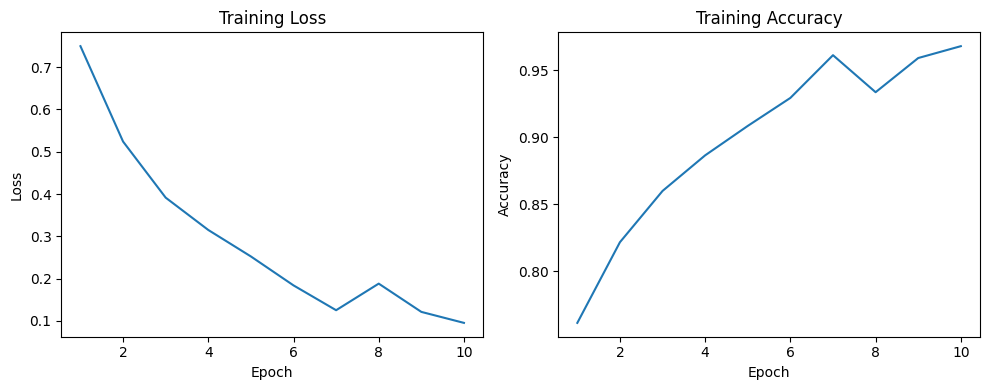


[LOSOCV Fold 17] Test Subject: 30
  Epoch 1/10 - Loss: 0.7304 - Acc: 0.7690
  Epoch 2/10 - Loss: 0.5498 - Acc: 0.8201
  Epoch 3/10 - Loss: 0.3878 - Acc: 0.8635
  Epoch 4/10 - Loss: 0.2911 - Acc: 0.9069
  Epoch 5/10 - Loss: 0.2335 - Acc: 0.9180
  Epoch 6/10 - Loss: 0.1869 - Acc: 0.9364
  Epoch 7/10 - Loss: 0.1644 - Acc: 0.9444
  Epoch 8/10 - Loss: 0.1476 - Acc: 0.9493
  Epoch 9/10 - Loss: 0.1099 - Acc: 0.9656
  Epoch 10/10 - Loss: 0.0748 - Acc: 0.9739


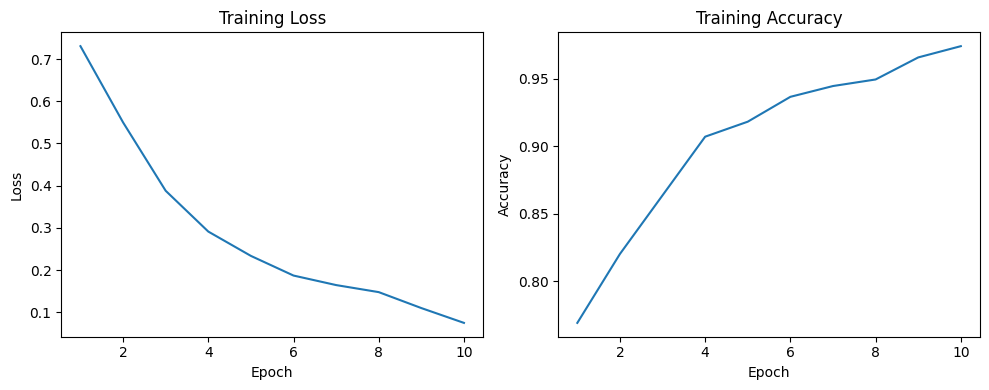


[LOSOCV Fold 18] Test Subject: 33
  Epoch 1/10 - Loss: 0.7330 - Acc: 0.7742
  Epoch 2/10 - Loss: 0.5341 - Acc: 0.8165
  Epoch 3/10 - Loss: 0.3721 - Acc: 0.8679
  Epoch 4/10 - Loss: 0.3229 - Acc: 0.8912
  Epoch 5/10 - Loss: 0.2468 - Acc: 0.9151
  Epoch 6/10 - Loss: 0.1920 - Acc: 0.9320
  Epoch 7/10 - Loss: 0.1610 - Acc: 0.9440
  Epoch 8/10 - Loss: 0.1069 - Acc: 0.9665
  Epoch 9/10 - Loss: 0.1187 - Acc: 0.9627
  Epoch 10/10 - Loss: 0.1065 - Acc: 0.9613


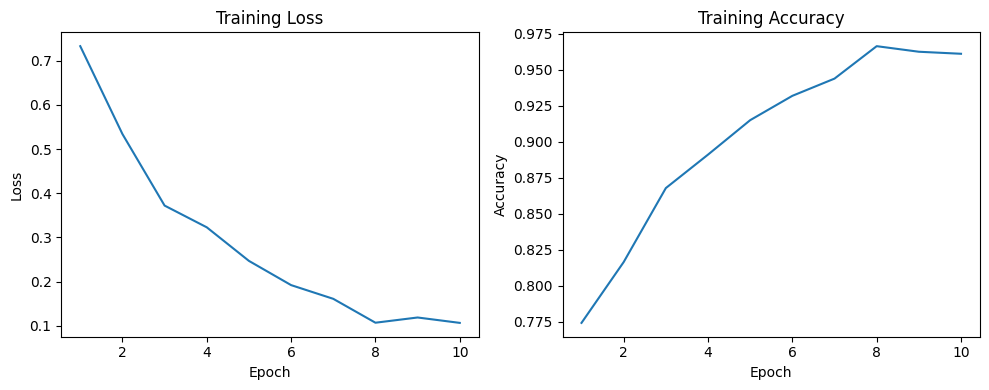

In [36]:
le_stroke_losocv = LabelEncoder().fit(y_stroke)
y_true_stroke_losocv, y_pred_stroke_losocv, y_scores_stroke_losocv = train_losocv_model(X_stroke, y_stroke, g_stroke, le_stroke_losocv, num_epochs=10)

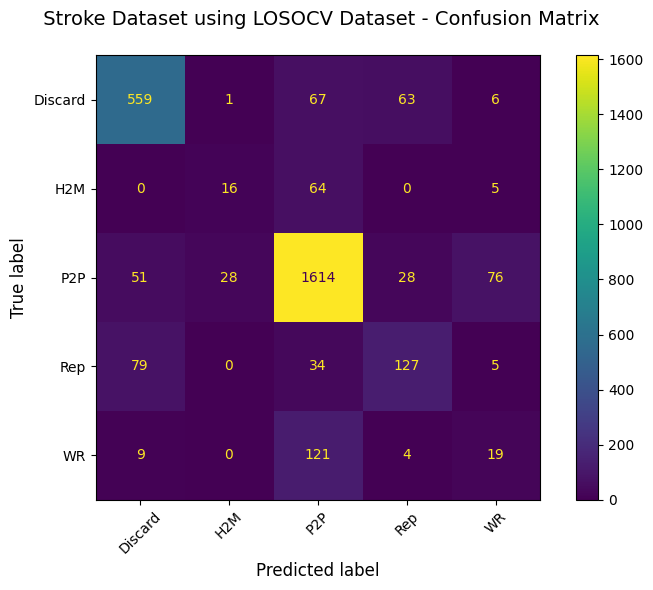

In [37]:
#Stroke Data Visualization using LOSOCV

y_true_stroke_losocv = np.array(y_true_stroke_losocv)
y_pred_stroke_losocv = np.array(y_pred_stroke_losocv)
y_scores_stroke_losocv = np.array(y_scores_stroke_losocv)

plot_conf_matrix(y_true_stroke_losocv, y_pred_stroke_losocv, label_encoder_stroke.classes_," Stroke Dataset using LOSOCV")

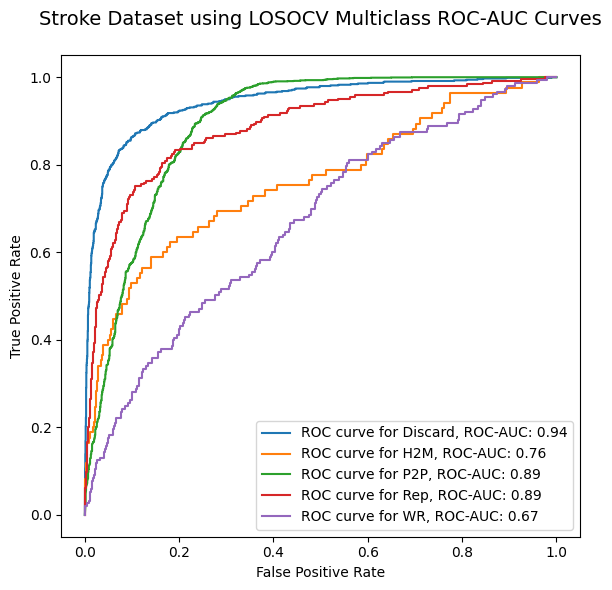

In [38]:
plot_multiclass_roc(y_true_stroke_losocv, y_scores_stroke_losocv, label_encoder_stroke, "Stroke Dataset using LOSOCV")

In [39]:
import numpy as np
import pandas as pd
import pickle

har_data_path = "/content/drive/My Drive/activity_data.npz"
har_data = np.load(har_data_path, allow_pickle=True)

print(har_data.files)

['data']


In [40]:
activity_data = har_data['data'].item()

In [41]:
def extract_windows_har(data_dict, window_size=100, stride=50):
    X, y, groups = [], [], []
    for (subj_id, label), data in data_dict.items():
        for i in range(0, len(data) - window_size + 1, stride):
            window = data[i:i+window_size]
            if window.shape[0] == window_size:
                img = generate_inertial_views(window)
                X.append(img)
                y.append(label)
                groups.append(subj_id)
    return np.array(X), np.array(y), np.array(groups)

In [42]:
import matplotlib.pyplot as plt
import numpy as np

def plot_rgb_har_samples(X, y, title_prefix="", max_samples=2):
    indices = np.random.choice(len(X), size=min(max_samples, len(X)), replace=False)
    for idx in indices:
        plt.imshow(X[idx])
        plt.title(f"{title_prefix} Label: {y[idx]}")
        plt.axis('off')
        plt.show()

In [43]:
from collections import Counter

print("=== HAR DATASET ===")
X_har, y_har, g_har = extract_windows_har(activity_data)
print(f"HAR Data: {X_har.shape}")

print(f"\n Unique lables in HAR data :{np.unique(y_har)}\n")

label_counts_har = Counter(y_har)
print("Label counts in full HAR dataset:")
for label, count in label_counts_har.items():
    print(f"{label}: {count}")

=== HAR DATASET ===
HAR Data: (20763, 128, 128, 3)

 Unique lables in HAR data :['climbingup' 'running' 'sitting' 'standing' 'walking']

Label counts in full HAR dataset:
climbingup: 2248
running: 5225
sitting: 4473
standing: 4351
walking: 4466


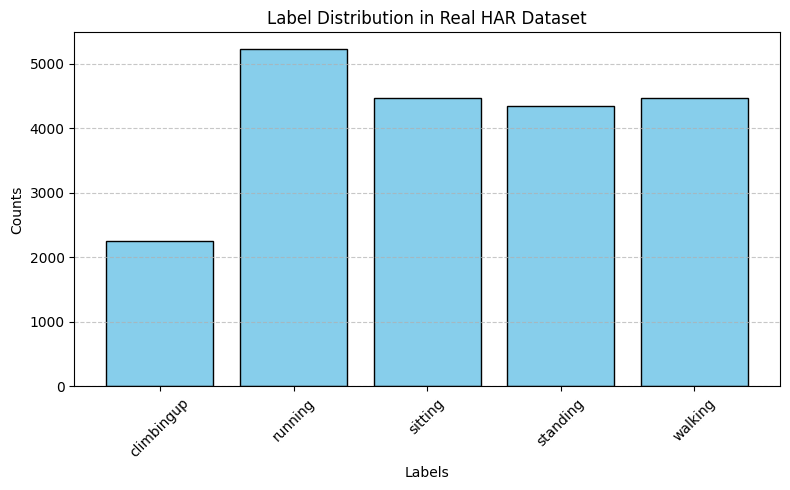

In [44]:
label_counts_har = Counter(y_har)

labels_har = list(label_counts_har.keys())
counts_har = list(label_counts_har.values())

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(labels_har, counts_har, color='skyblue', edgecolor='black')
plt.title("Label Distribution in Real HAR Dataset")
plt.xlabel("Labels")
plt.ylabel("Counts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

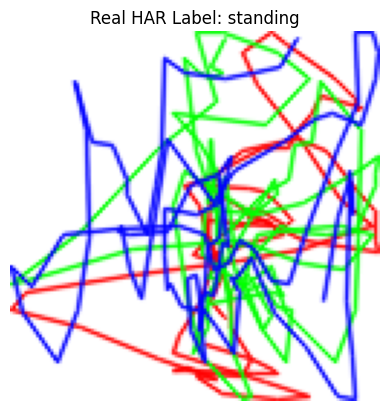

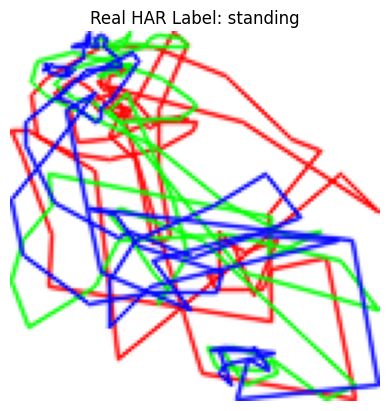

In [45]:
plot_rgb_har_samples(X_har, y_har, "Real HAR")


Fold 1/5
  Train subjects: [1 2 6 3 5]
  Test subjects: [4 7]
  Train label counts: {np.str_('climbingup'): 2248, np.str_('running'): 3458, np.str_('sitting'): 3197, np.str_('standing'): 3094, np.str_('walking'): 3238}
  Test label counts: {np.str_('running'): 1767, np.str_('sitting'): 1276, np.str_('standing'): 1257, np.str_('walking'): 1228}

Fold 2/5
  Train subjects: [6 1 4 3 2]
  Test subjects: [7 5]
  Train label counts: {np.str_('climbingup'): 1644, np.str_('running'): 3385, np.str_('sitting'): 3178, np.str_('standing'): 3098, np.str_('walking'): 3162}
  Test label counts: {np.str_('climbingup'): 604, np.str_('running'): 1840, np.str_('sitting'): 1295, np.str_('standing'): 1253, np.str_('walking'): 1304}

Fold 3/5
  Train subjects: [1 2 7 6 4]
  Test subjects: [5 3]
  Train label counts: {np.str_('climbingup'): 1051, np.str_('running'): 3362, np.str_('sitting'): 3197, np.str_('standing'): 3135, np.str_('walking'): 3098}
  Test label counts: {np.str_('climbingup'): 1197, np.str_

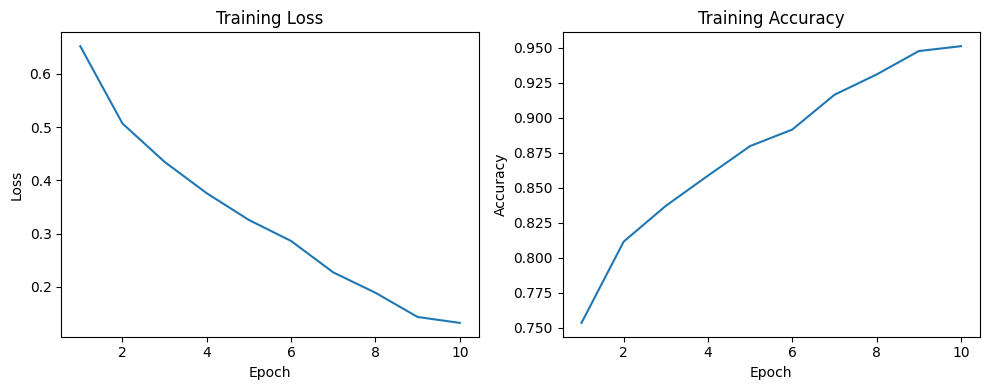


====== Fold 2 ======
  Epoch 1/10 - Loss: 0.6904 - Acc: 0.7372
  Epoch 2/10 - Loss: 0.5541 - Acc: 0.7972
  Epoch 3/10 - Loss: 0.4827 - Acc: 0.8225
  Epoch 4/10 - Loss: 0.4277 - Acc: 0.8425
  Epoch 5/10 - Loss: 0.3588 - Acc: 0.8678
  Epoch 6/10 - Loss: 0.3067 - Acc: 0.8858
  Epoch 7/10 - Loss: 0.2550 - Acc: 0.9110
  Epoch 8/10 - Loss: 0.2149 - Acc: 0.9217
  Epoch 9/10 - Loss: 0.1727 - Acc: 0.9369
  Epoch 10/10 - Loss: 0.1466 - Acc: 0.9476


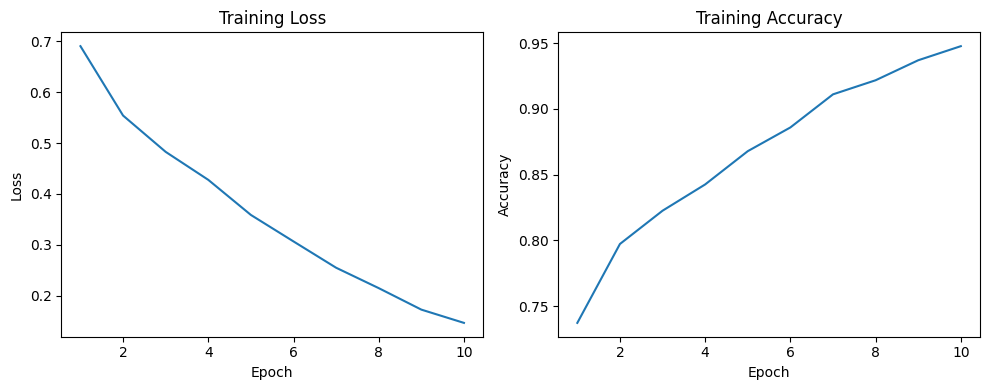


====== Fold 3 ======
  Epoch 1/10 - Loss: 0.6672 - Acc: 0.7539
  Epoch 2/10 - Loss: 0.5218 - Acc: 0.8089
  Epoch 3/10 - Loss: 0.4534 - Acc: 0.8293
  Epoch 4/10 - Loss: 0.3989 - Acc: 0.8498
  Epoch 5/10 - Loss: 0.3472 - Acc: 0.8731
  Epoch 6/10 - Loss: 0.2850 - Acc: 0.8941
  Epoch 7/10 - Loss: 0.2302 - Acc: 0.9146
  Epoch 8/10 - Loss: 0.1793 - Acc: 0.9377
  Epoch 9/10 - Loss: 0.1457 - Acc: 0.9475
  Epoch 10/10 - Loss: 0.1285 - Acc: 0.9553


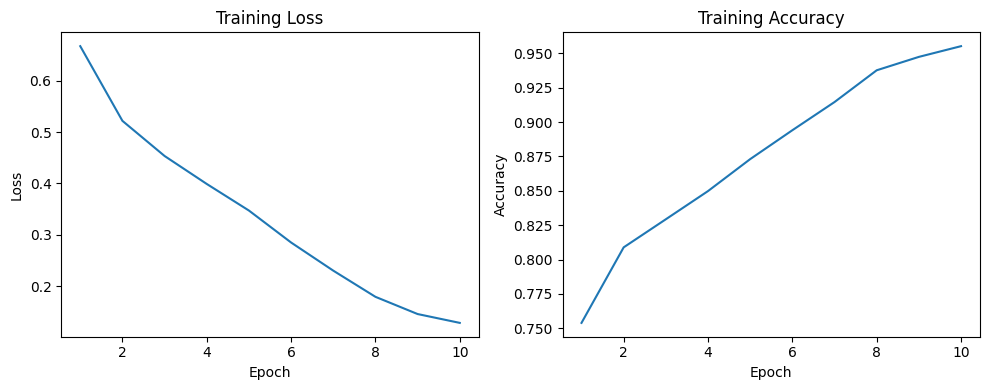


====== Fold 4 ======
  Epoch 1/10 - Loss: 0.7098 - Acc: 0.7307
  Epoch 2/10 - Loss: 0.5607 - Acc: 0.7851
  Epoch 3/10 - Loss: 0.4934 - Acc: 0.8131
  Epoch 4/10 - Loss: 0.4285 - Acc: 0.8375
  Epoch 5/10 - Loss: 0.3705 - Acc: 0.8624
  Epoch 6/10 - Loss: 0.3129 - Acc: 0.8821
  Epoch 7/10 - Loss: 0.2457 - Acc: 0.9089
  Epoch 8/10 - Loss: 0.1959 - Acc: 0.9266
  Epoch 9/10 - Loss: 0.1489 - Acc: 0.9480
  Epoch 10/10 - Loss: 0.1288 - Acc: 0.9534


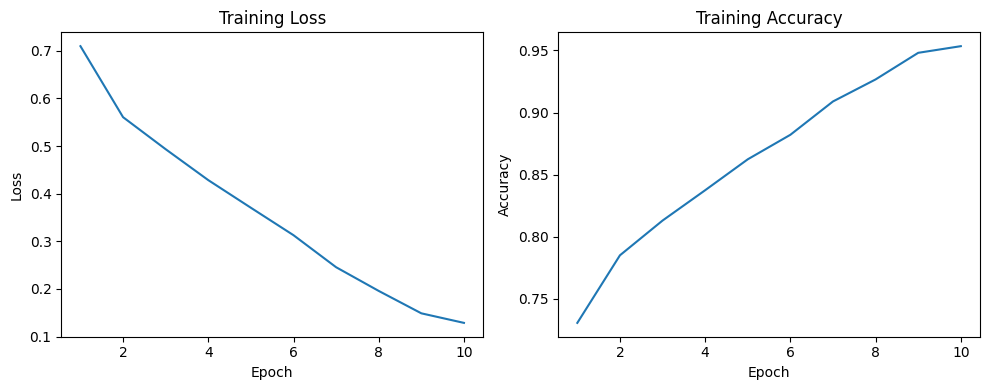


====== Fold 5 ======
  Epoch 1/10 - Loss: 0.6016 - Acc: 0.7771
  Epoch 2/10 - Loss: 0.4396 - Acc: 0.8399
  Epoch 3/10 - Loss: 0.3745 - Acc: 0.8663
  Epoch 4/10 - Loss: 0.3185 - Acc: 0.8832
  Epoch 5/10 - Loss: 0.2585 - Acc: 0.9061
  Epoch 6/10 - Loss: 0.2244 - Acc: 0.9195
  Epoch 7/10 - Loss: 0.1801 - Acc: 0.9353
  Epoch 8/10 - Loss: 0.1476 - Acc: 0.9461
  Epoch 9/10 - Loss: 0.1064 - Acc: 0.9616
  Epoch 10/10 - Loss: 0.1040 - Acc: 0.9626


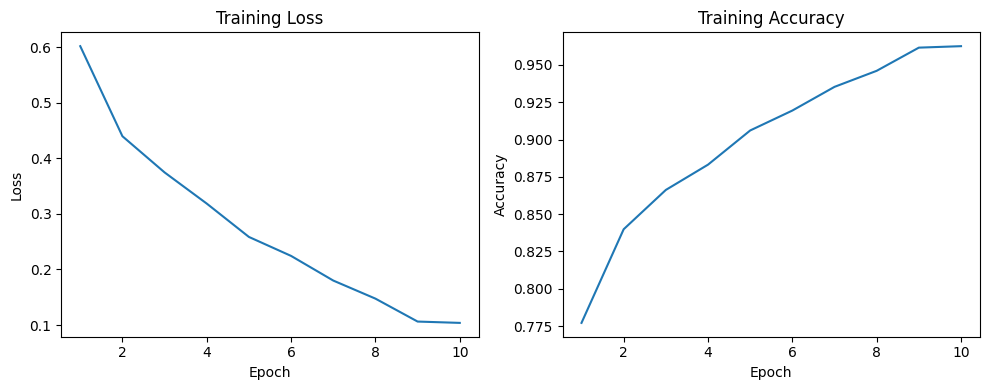

In [46]:
label_encoder_har = LabelEncoder().fit(y_har)

#repeated subject splits (7-fold, stratified)
splits = repeated_subject_stratified_split(X_har, y_har, g_har, n_splits=5)

all_y_har_true, all_y_har_pred, all_y_har_scores = [], [], []

# Train and evaluate on each fold
for i, (X_train, y_train, X_test, y_test) in enumerate(splits, 1):
    print(f"\n====== Fold {i} ======")
    yt_har, yp_har, ys_har = train_on_split(X_train, y_train, X_test, y_test, label_encoder_har)
    all_y_har_true.extend(yt_har)
    all_y_har_pred.extend(yp_har)
    all_y_har_scores.extend(ys_har)

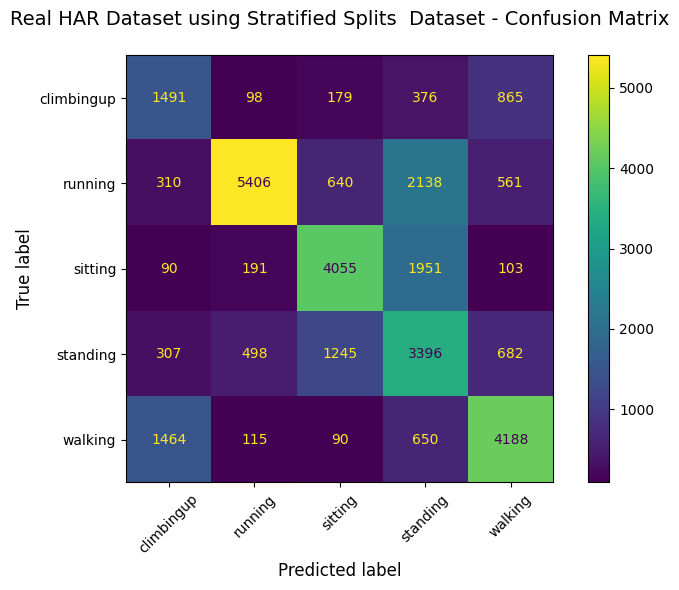

In [48]:
# Real HAR Data Visualization using Stratified Splits

y_har_true = np.array(all_y_har_true)
y_har_pred = np.array(all_y_har_pred)
y_har_scores = np.array(all_y_har_scores)

plot_conf_matrix(y_har_true, y_har_pred, label_encoder_har.classes_, "Real HAR Dataset using Stratified Splits ")

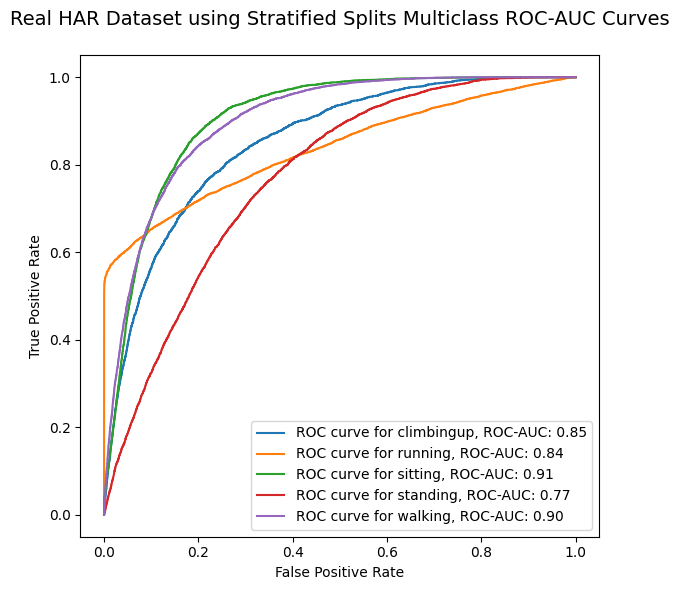

In [49]:
plot_multiclass_roc(y_har_true, y_har_scores,label_encoder_har, "Real HAR Dataset using Stratified Splits")


[LOSOCV Fold 1] Test Subject: 1
  Epoch 1/10 - Loss: 0.7113 - Acc: 0.7290
  Epoch 2/10 - Loss: 0.5601 - Acc: 0.7848
  Epoch 3/10 - Loss: 0.4893 - Acc: 0.8146
  Epoch 4/10 - Loss: 0.4395 - Acc: 0.8344
  Epoch 5/10 - Loss: 0.3720 - Acc: 0.8582
  Epoch 6/10 - Loss: 0.3228 - Acc: 0.8774
  Epoch 7/10 - Loss: 0.2513 - Acc: 0.9038
  Epoch 8/10 - Loss: 0.1992 - Acc: 0.9281
  Epoch 9/10 - Loss: 0.1592 - Acc: 0.9418
  Epoch 10/10 - Loss: 0.1239 - Acc: 0.9556


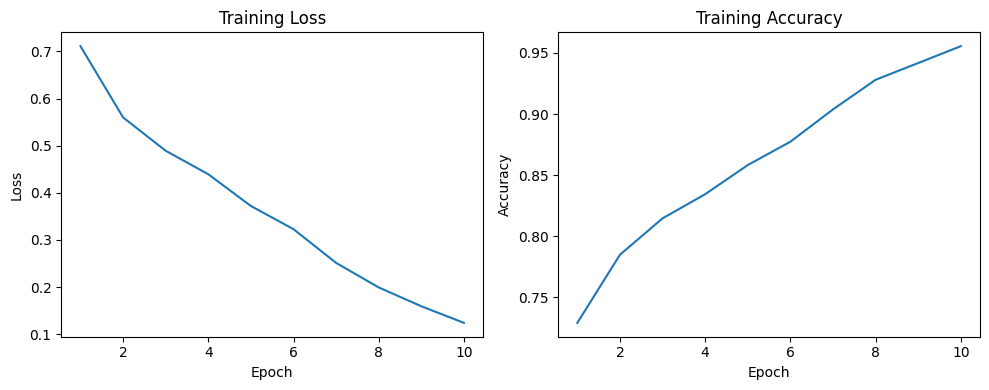


[LOSOCV Fold 2] Test Subject: 2
  Epoch 1/10 - Loss: 0.7429 - Acc: 0.7088
  Epoch 2/10 - Loss: 0.5944 - Acc: 0.7691
  Epoch 3/10 - Loss: 0.5250 - Acc: 0.7974
  Epoch 4/10 - Loss: 0.4634 - Acc: 0.8214
  Epoch 5/10 - Loss: 0.4089 - Acc: 0.8419
  Epoch 6/10 - Loss: 0.3502 - Acc: 0.8645
  Epoch 7/10 - Loss: 0.2983 - Acc: 0.8873
  Epoch 8/10 - Loss: 0.2420 - Acc: 0.9106
  Epoch 9/10 - Loss: 0.1882 - Acc: 0.9299
  Epoch 10/10 - Loss: 0.1540 - Acc: 0.9454


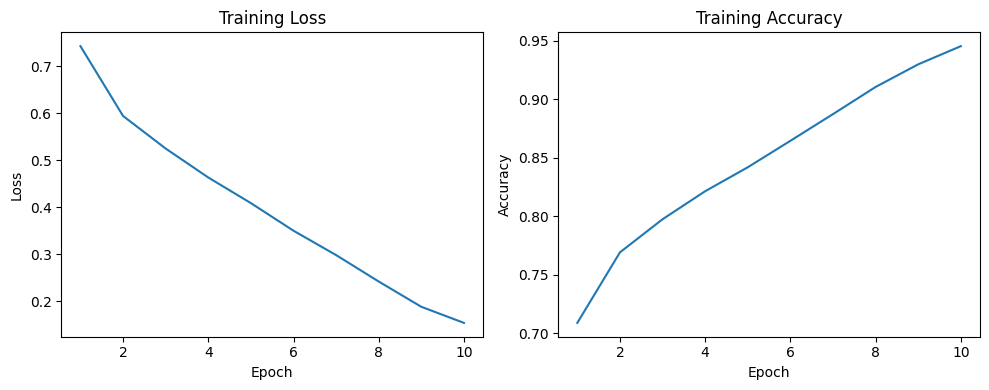


[LOSOCV Fold 3] Test Subject: 3
  Epoch 1/10 - Loss: 0.7231 - Acc: 0.7224
  Epoch 2/10 - Loss: 0.5738 - Acc: 0.7825
  Epoch 3/10 - Loss: 0.5054 - Acc: 0.8074
  Epoch 4/10 - Loss: 0.4501 - Acc: 0.8289
  Epoch 5/10 - Loss: 0.4010 - Acc: 0.8462
  Epoch 6/10 - Loss: 0.3407 - Acc: 0.8682
  Epoch 7/10 - Loss: 0.2824 - Acc: 0.8924
  Epoch 8/10 - Loss: 0.2268 - Acc: 0.9162
  Epoch 9/10 - Loss: 0.1730 - Acc: 0.9363
  Epoch 10/10 - Loss: 0.1390 - Acc: 0.9484


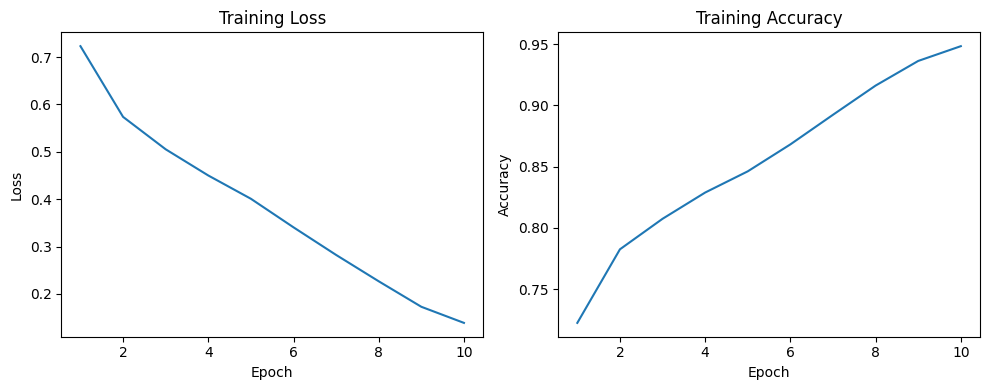


[LOSOCV Fold 4] Test Subject: 4
  Epoch 1/10 - Loss: 0.6574 - Acc: 0.7510
  Epoch 2/10 - Loss: 0.4954 - Acc: 0.8135
  Epoch 3/10 - Loss: 0.4331 - Acc: 0.8319
  Epoch 4/10 - Loss: 0.3743 - Acc: 0.8558
  Epoch 5/10 - Loss: 0.3204 - Acc: 0.8785
  Epoch 6/10 - Loss: 0.2638 - Acc: 0.8992
  Epoch 7/10 - Loss: 0.2172 - Acc: 0.9196
  Epoch 8/10 - Loss: 0.1816 - Acc: 0.9339
  Epoch 9/10 - Loss: 0.1466 - Acc: 0.9459
  Epoch 10/10 - Loss: 0.1126 - Acc: 0.9616


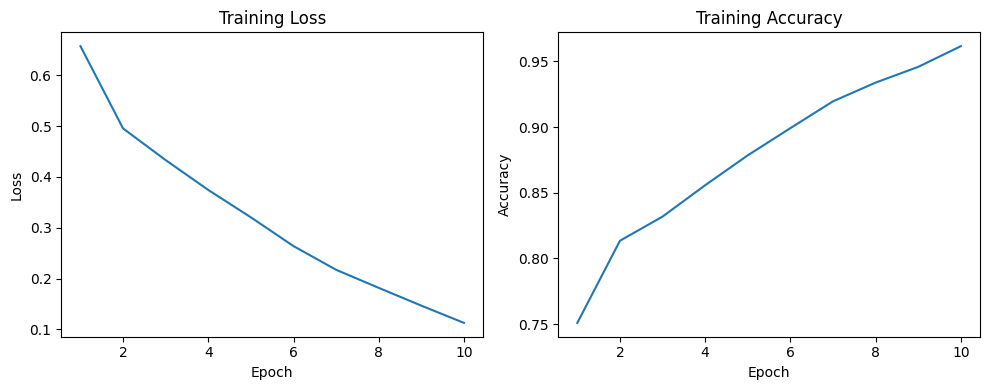


[LOSOCV Fold 5] Test Subject: 5
  Epoch 1/10 - Loss: 0.6727 - Acc: 0.7483
  Epoch 2/10 - Loss: 0.5288 - Acc: 0.8054
  Epoch 3/10 - Loss: 0.4723 - Acc: 0.8288
  Epoch 4/10 - Loss: 0.4133 - Acc: 0.8482
  Epoch 5/10 - Loss: 0.3494 - Acc: 0.8706
  Epoch 6/10 - Loss: 0.2989 - Acc: 0.8913
  Epoch 7/10 - Loss: 0.2451 - Acc: 0.9085
  Epoch 8/10 - Loss: 0.2051 - Acc: 0.9281
  Epoch 9/10 - Loss: 0.1513 - Acc: 0.9443
  Epoch 10/10 - Loss: 0.1269 - Acc: 0.9529


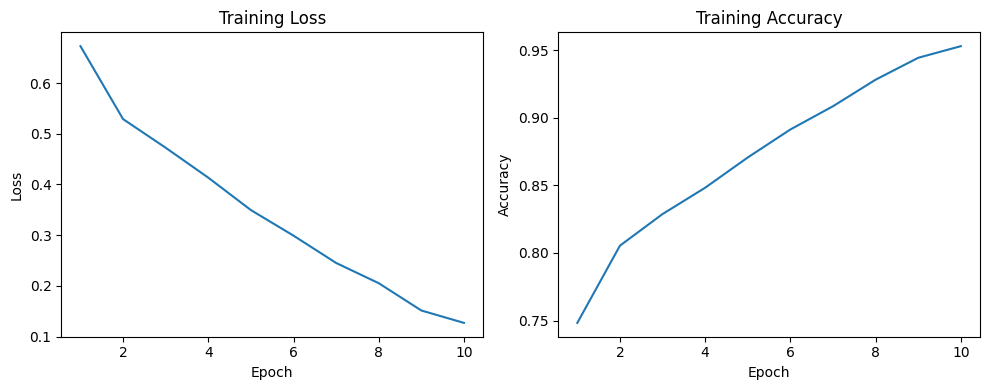


[LOSOCV Fold 6] Test Subject: 6
  Epoch 1/10 - Loss: 0.7232 - Acc: 0.7215
  Epoch 2/10 - Loss: 0.5791 - Acc: 0.7788
  Epoch 3/10 - Loss: 0.5114 - Acc: 0.8014
  Epoch 4/10 - Loss: 0.4590 - Acc: 0.8206
  Epoch 5/10 - Loss: 0.3915 - Acc: 0.8508
  Epoch 6/10 - Loss: 0.3412 - Acc: 0.8679
  Epoch 7/10 - Loss: 0.2795 - Acc: 0.8922
  Epoch 8/10 - Loss: 0.2329 - Acc: 0.9115
  Epoch 9/10 - Loss: 0.1852 - Acc: 0.9321
  Epoch 10/10 - Loss: 0.1398 - Acc: 0.9486


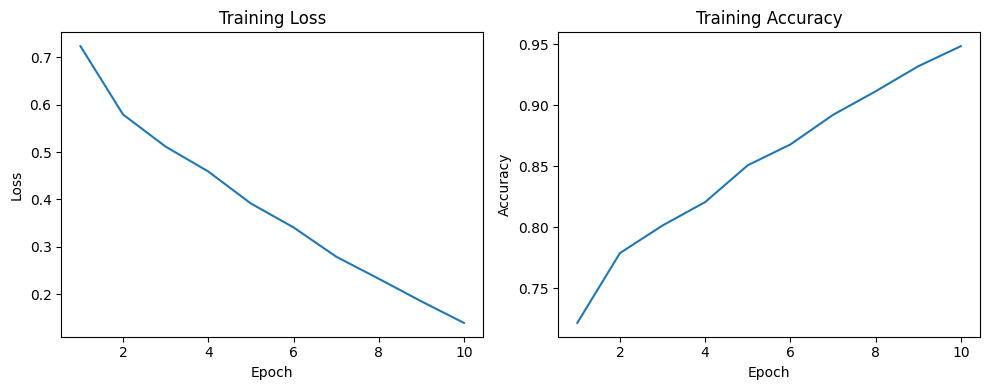


[LOSOCV Fold 7] Test Subject: 7
  Epoch 1/10 - Loss: 0.7239 - Acc: 0.7228
  Epoch 2/10 - Loss: 0.5772 - Acc: 0.7796
  Epoch 3/10 - Loss: 0.5076 - Acc: 0.8086
  Epoch 4/10 - Loss: 0.4477 - Acc: 0.8306
  Epoch 5/10 - Loss: 0.3896 - Acc: 0.8540
  Epoch 6/10 - Loss: 0.3255 - Acc: 0.8772
  Epoch 7/10 - Loss: 0.2776 - Acc: 0.8947
  Epoch 8/10 - Loss: 0.2175 - Acc: 0.9197
  Epoch 9/10 - Loss: 0.1792 - Acc: 0.9343
  Epoch 10/10 - Loss: 0.1352 - Acc: 0.9515


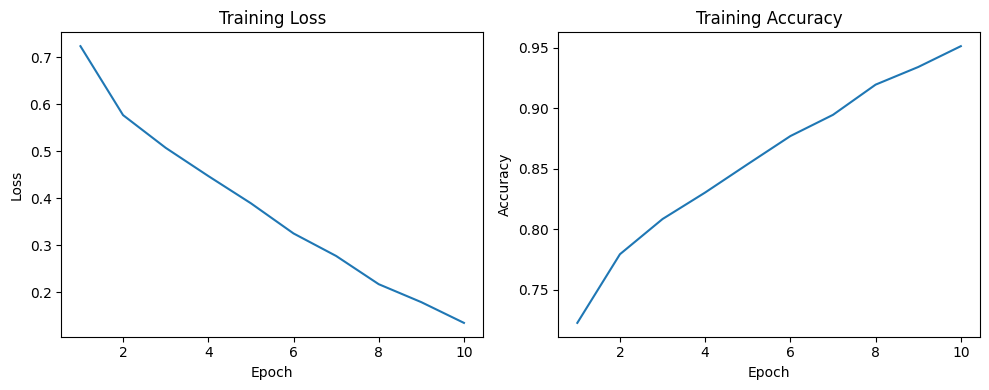

In [51]:
le_har_losocv = LabelEncoder().fit(y_har)
y_true_har_losocv, y_pred_har_losocv, y_scores_har_losocv = train_losocv_model(X_har, y_har, g_har, le_har_losocv, num_epochs=10)

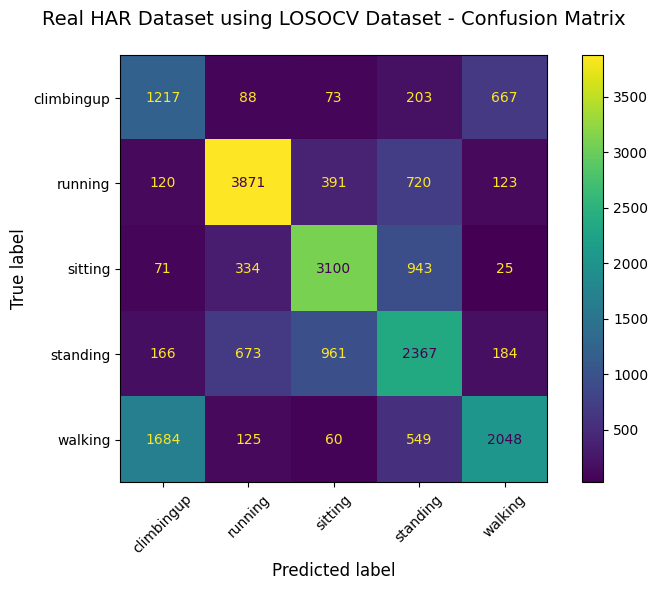

In [55]:
#Real HAR Data Visualization using LOSOCV

y_true_har_losocv = np.array(y_true_har_losocv)
y_pred_har_losocv = np.array(y_pred_har_losocv)
y_scores_har_losocv = np.array(y_scores_har_losocv)

plot_conf_matrix(y_true_har_losocv, y_pred_har_losocv, label_encoder_har.classes_,"Real HAR Dataset using LOSOCV")

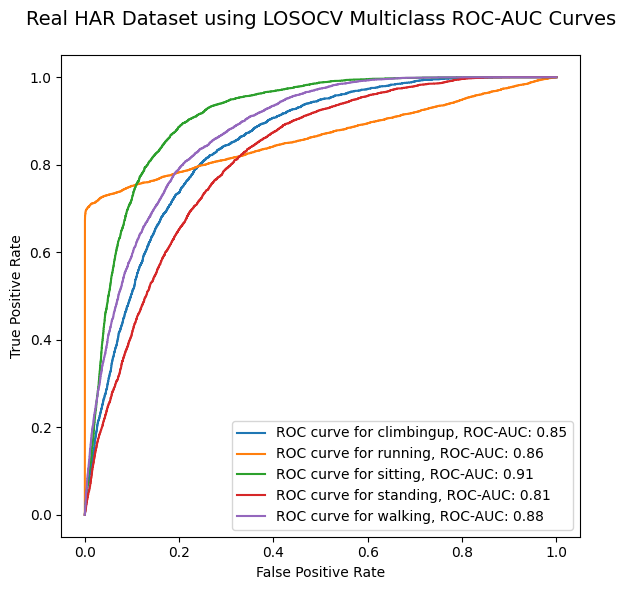

In [56]:
plot_multiclass_roc(y_true_har_losocv, y_scores_har_losocv,label_encoder_har, "Real HAR Dataset using LOSOCV")